#### Housekeeping

In [115]:
%reset -f

import pandas as pd
import numpy as np
# import folium   
import os
# import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 16})
from matplotlib.transforms import ScaledTranslation
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.ticker import AutoLocator
import seaborn as sns

import nrarfcn as nr
# https://gitlab.com/alexander_marder/earfcn
# https://pypi.org/project/earfcn/0.0.3/
from earfcn.convert import earfcn2freq

In [116]:
df_5g_pdsch = pd.read_csv('../_data/Spring2025_ArkansasNH/5g_pdsch.csv', sep=';')
df_5g_pdsch = df_5g_pdsch[(df_5g_pdsch['Test Status']=='Completed') & (df_5g_pdsch['Direction']=='Downlink')]
df_5g_pusch = pd.read_csv('../_data/Spring2025_ArkansasNH/5g_pusch.csv', sep=';')
df_5g_pusch = df_5g_pusch[(df_5g_pusch['Test Status']=='Completed') & (df_5g_pusch['Direction']=='Uplink')]

df_lte_pdsch = pd.read_csv('../_data/Spring2025_ArkansasNH/lte_pdsch.csv', sep=';')
df_lte_pdsch = df_lte_pdsch[(df_lte_pdsch['Test Status']=='Completed') & (df_lte_pdsch['Direction']=='Downlink')]
df_lte_pusch = pd.read_csv('../_data/Spring2025_ArkansasNH/lte_pusch.csv', sep=';')
df_lte_pusch = df_lte_pusch[(df_lte_pusch['Test Status']=='Completed') & (df_lte_pusch['Direction']=='Uplink')]

#### 5G-LTE Combining Shared Channel

In [117]:
# Frequency calculation processing

df_5g_pdsch = df_5g_pdsch.dropna(subset=['DL NR-ARFCN'])
df_5g_pdsch['DL NR-ARFCN'] = df_5g_pdsch['DL NR-ARFCN'].astype(int)
df_5g_pdsch['DL Freq'] = df_5g_pdsch['DL NR-ARFCN'].apply(nr.get_frequency)
df_5g_pdsch['DL Freq'] = df_5g_pdsch['DL Freq'].round(-1)

df_lte_pdsch = df_lte_pdsch.dropna(subset=['DL EARFCN'])
df_lte_pdsch['DL Freq'] = df_lte_pdsch['DL EARFCN'].apply(earfcn2freq)
df_lte_pdsch['DL Freq'] = df_lte_pdsch['DL Freq'].round(-1)


# df_5g_pusch = df_5g_pusch.dropna(subset=['UL NR-ARFCN'])
# df_5g_pusch['UL NR-ARFCN'] = df_5g_pusch['UL NR-ARFCN'].astype(int)
# df_5g_pusch['UL Freq'] = df_5g_pusch['UL NR-ARFCN'].apply(nr.get_frequency)
# df_5g_pusch['UL Freq'] = df_5g_pusch['UL Freq'].round(-1)

# df_lte_pusch = df_lte_pusch.dropna(subset=['UL EARFCN'])
# df_lte_pusch['UL Freq'] = df_lte_pusch['UL EARFCN'].apply(earfcn2freq)
# df_lte_pusch['UL Freq'] = df_lte_pusch['UL Freq'].round(-1)

In [118]:
### Renaming LTE & 5G PDSCH Columns
df_lte_pdsch.rename(columns={'RB per Subframe': 'RB per Subframe-Slot'}, inplace=True)
df_5g_pdsch.rename(columns={'Avg Num PDSCH RBs per Slot': 'RB per Subframe-Slot'}, inplace=True)
df_5g_pdsch.rename(columns={'Num PDSCH RBs': 'RBs'}, inplace=True)
df_5g_pdsch.rename(columns={'PDSCH BLER': 'BLER'}, inplace=True)
df_lte_pdsch.rename(columns={'LTE Net PDSCH Throughput': 'Net PDSCH Throughput'}, inplace=True)
df_5g_pdsch.rename(columns={'5G NR Net PDSCH Throughput': 'Net PDSCH Throughput'}, inplace=True)
df_lte_pdsch.rename(columns={'PCI LTE': 'PCI'}, inplace=True)
df_5g_pdsch.rename(columns={'PCI 5G NR': 'PCI'}, inplace=True)

### PDSCH Norm TP Calculation
df_lte_pdsch['Normalized Throughput'] = (df_lte_pdsch['Net PDSCH Throughput'] * 1e3) / (df_lte_pdsch['RB per Subframe-Slot'] * 15e3 * 12 * df_lte_pdsch['Avg PDSCH Layers'])
df_5g_pdsch['Normalized Throughput'] = (df_5g_pdsch['Net PDSCH Throughput'] * 1e3) / (df_5g_pdsch['RB per Subframe-Slot'] * df_5g_pdsch['PDSCH SCS'] * 1e3 * 12 * df_5g_pdsch['Avg PDSCH Layers'])
df_lte_pdsch.dropna(subset=['Normalized Throughput'], inplace=True)
df_5g_pdsch.dropna(subset=['Normalized Throughput'], inplace=True)

In [119]:
### Renaming LTE & 5G PUSCH Columns
df_lte_pusch.rename(columns={'RB per Subframe': 'RB per Subframe-Slot'}, inplace=True)
df_5g_pusch.rename(columns={'Avg Num PUSCH RBs per Slot': 'RB per Subframe-Slot'}, inplace=True)
df_5g_pusch.rename(columns={'Num PUSCH RBs': 'RBs'}, inplace=True)
df_5g_pusch.rename(columns={'PUSCH BLER': 'BLER'}, inplace=True)
df_lte_pusch.rename(columns={'LTE Net PUSCH Throughput': 'Net PUSCH Throughput'}, inplace=True)
df_5g_pusch.rename(columns={'5G NR Net PUSCH Throughput': 'Net PUSCH Throughput'}, inplace=True)
df_lte_pusch.rename(columns={'PCI LTE': 'PCI'}, inplace=True)
df_5g_pusch.rename(columns={'PCI 5G NR': 'PCI'}, inplace=True)

### PUSCH Norm TP Calculation
df_lte_pusch['Normalized Throughput'] = (df_lte_pusch['Net PUSCH Throughput'] * 1e3) / (df_lte_pusch['RB per Subframe-Slot'] * 15e3 * 12 * 1) # df_lte_pusch['Avg PUSCH Layers'])=1 for all measurements from UL Layer Summary in SmartAnalytics 
df_5g_pusch['Normalized Throughput'] = (df_5g_pusch['Net PUSCH Throughput'] * 1e3) / (df_5g_pusch['RB per Subframe-Slot'] * df_5g_pusch['PUSCH SCS'] * 1e3 * 12 * df_5g_pusch['Avg PUSCH Layers'])
df_lte_pusch.dropna(subset=['Normalized Throughput'], inplace=True)
df_5g_pusch.dropna(subset=['Normalized Throughput'], inplace=True)

#### PDSCH

##### Data cleaning

In [120]:
print(df_lte_pdsch['Collection'].value_counts().sort_index())

Collection
Day1-ATT-MNO-DEF-IN        693
Day1-ATT-MNO-DEF-OUT       518
Day1-ATT-NH-IN             529
Day1-ATT-NH-OUT             78
Day1-TMO-MNO-DEF-IN        222
Day1-TMO-NH-IN             802
Day1-TMO-NH-OUT             39
Day2-ATT-MNO-4G-IN         769
Day2-ATT-MNO-4G-OUT        607
Day2-ATT-MNO-DEF-IN        737
Day2-ATT-MNO-DEF-OUT       763
Day2-ATT-MNO-DEF-OUTER     668
Day2-TMO-MNO-4G-IN         715
Day2-TMO-MNO-4G-OUT       1038
Day2-VZN-MNO-4G-IN         862
Day2-VZN-MNO-4G-OUT        704
Day2-VZN-MNO-DEF-IN        767
Day2-VZN-MNO-DEF-OUT       319
Day2-VZN-MNO-DEF-OUTER     287
Day3_ATT-MNO-DEF-IN-L1     758
Day3_ATT-MNO-DEF-IN-L2     566
Day3_ATT-NH-IN-L1          294
Day3_ATT-NH-IN-L2          457
Day3_TMO-DEF-L1-V1           9
Day3_TMO-NH-L1             526
Day3_TMO-NH-L2             249
Day3_unnamed                82
Name: count, dtype: int64


In [121]:
df_lte_pdsch_att_nh_in = df_lte_pdsch[df_lte_pdsch['Collection']=='Day1-ATT-NH-IN']
df_lte_pdsch_att_nh_out = df_lte_pdsch[df_lte_pdsch['Collection']=='Day1-ATT-NH-OUT']

df_lte_pdsch_att_mno_in = pd.concat([df_lte_pdsch[df_lte_pdsch['Collection']=='Day1-ATT-MNO-DEF-IN'],
                                    df_lte_pdsch[df_lte_pdsch['Collection']=='Day2-ATT-MNO-4G-IN'],
                                    df_lte_pdsch[df_lte_pdsch['Collection']=='Day2-ATT-MNO-DEF-IN']],
                                    ignore_index=True)
df_lte_pdsch_att_mno_out = pd.concat([df_lte_pdsch[df_lte_pdsch['Collection']=='Day1-ATT-MNO-DEF-OUT'],
                                    df_lte_pdsch[df_lte_pdsch['Collection']=='Day2-ATT-MNO-4G-OUT'],
                                    df_lte_pdsch[df_lte_pdsch['Collection']=='Day2-ATT-MNO-DEF-OUT']],
                                    # df_lte_pdsch[df_lte_pdsch['Collection']=='Day2-ATT-MNO-DEF-OUTER']],
                                    ignore_index=True)

df_lte_pdsch_tmo_nh_in = df_lte_pdsch[df_lte_pdsch['Collection']=='Day1-TMO-NH-IN']
df_lte_pdsch_tmo_nh_out = df_lte_pdsch[df_lte_pdsch['Collection']=='Day1-TMO-NH-OUT']

df_lte_pdsch_tmo_mno_in = pd.concat([df_lte_pdsch[df_lte_pdsch['Collection']=='Day1-TMO-MNO-DEF-IN'],
                                    df_lte_pdsch[df_lte_pdsch['Collection']=='Day2-TMO-MNO-4G-IN']],
                                    ignore_index=True)
df_lte_pdsch_tmo_mno_out = df_lte_pdsch[df_lte_pdsch['Collection']=='Day2-TMO-MNO-4G-OUT']

df_lte_pdsch_vzn_mno_in = pd.concat([df_lte_pdsch[df_lte_pdsch['Collection']=='Day2-VZN-MNO-4G-IN'],
                                    df_lte_pdsch[df_lte_pdsch['Collection']=='Day2-VZN-MNO-DEF-IN']],
                                    ignore_index=True)
df_lte_pdsch_vzn_mno_out = pd.concat([df_lte_pdsch[df_lte_pdsch['Collection']=='Day2-VZN-MNO-4G-OUT'],
                                    df_lte_pdsch[df_lte_pdsch['Collection']=='Day2-VZN-MNO-DEF-OUT']],
                                    # df_lte_pdsch[df_lte_pdsch['Collection']=='Day2-VZN-MNO-DEF-OUTER']],
                                    ignore_index=True)

In [122]:
print(df_5g_pdsch['Collection'].value_counts().sort_index())

Collection
Day1-TMO-MNO-DEF-IN       1747
Day1-TMO-MNO-DEF-OUT      1579
Day2-TMO-MNO-DEF-IN        853
Day2-TMO-MNO-DEF-OUT      1283
Day2-TMO-MNO-DEF-OUTER     990
Day2-VZN-MNO-DEF-IN        460
Day2-VZN-MNO-DEF-OUT       631
Day2-VZN-MNO-DEF-OUTER     638
Day3_TMO-DEF-IN-L2         149
Day3_TMO-DEF-L1-V1         215
Day3_TMO-DEF-L2            113
Name: count, dtype: int64


In [123]:
df_5g_pdsch_tmo_mno_in = pd.concat([df_5g_pdsch[df_5g_pdsch['Collection']=='Day1-TMO-MNO-DEF-IN'],
                                    df_5g_pdsch[df_5g_pdsch['Collection']=='Day2-TMO-MNO-DEF-IN']],
                                    ignore_index=True)
df_5g_pdsch_tmo_mno_out = pd.concat([df_5g_pdsch[df_5g_pdsch['Collection']=='Day1-TMO-MNO-DEF-OUT'],
                                    df_5g_pdsch[df_5g_pdsch['Collection']=='Day2-TMO-MNO-DEF-OUT']],
                                    # df_5g_pdsch[df_5g_pdsch['Collection']=='Day2-TMO-MNO-DEF-OUTER']],
                                    ignore_index=True)

df_5g_pdsch_vzn_mno_in = df_5g_pdsch[df_5g_pdsch['Collection']=='Day2-VZN-MNO-DEF-IN']
df_5g_pdsch_vzn_mno_out = pd.concat([df_5g_pdsch[df_5g_pdsch['Collection']=='Day2-VZN-MNO-DEF-OUT']],
                                    # df_5g_pdsch[df_5g_pdsch['Collection']=='Day2-VZN-MNO-DEF-OUTER']],
                                    ignore_index=True)

##### print(): Statistics summary

In [124]:
print('LTE ATT NH IN')
print(df_lte_pdsch_att_nh_in[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('LTE ATT NH OUT')
print(df_lte_pdsch_att_nh_out[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('LTE ATT MNO IN')
print(df_lte_pdsch_att_mno_in[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('LTE ATT MNO OUT')
print(df_lte_pdsch_att_mno_out[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())

LTE ATT NH IN
Band Number  DL Freq  DL Bandwidth
48.0         3560.0   20.0            127
             3590.0   20.0            133
             3620.0   20.0             22
             3650.0   20.0            118
             3690.0   20.0            129
Name: count, dtype: int64
LTE ATT NH OUT
Band Number  DL Freq  DL Bandwidth
48.0         3560.0   20.0            34
             3650.0   20.0            44
Name: count, dtype: int64
LTE ATT MNO IN
Band Number  DL Freq  DL Bandwidth
2.0          1940.0   10.0            337
             1980.0   15.0            788
12.0         740.0    10.0            367
14.0         760.0    10.0            163
30.0         2360.0   10.0            384
66.0         2180.0   10.0            160
Name: count, dtype: int64
LTE ATT MNO OUT
Band Number  DL Freq  DL Bandwidth
2.0          1940.0   10.0            347
             1980.0   15.0            903
14.0         760.0    10.0            162
30.0         2360.0   10.0            232
66.0      

In [125]:
print('LTE TMO NH IN')
print(df_lte_pdsch_tmo_nh_in[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('LTE TMO NH OUT')
print(df_lte_pdsch_tmo_nh_out[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('LTE TMO MNO IN')
print(df_lte_pdsch_tmo_mno_in[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('LTE TMO MNO OUT')
print(df_lte_pdsch_tmo_mno_out[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())

LTE TMO NH IN
Band Number  DL Freq  DL Bandwidth
48.0         3560.0   20.0            220
             3590.0   20.0            206
             3620.0   20.0             21
             3650.0   20.0            180
             3690.0   20.0            175
Name: count, dtype: int64
LTE TMO NH OUT
Band Number  DL Freq  DL Bandwidth
48.0         3560.0   20.0            22
             3650.0   20.0            17
Name: count, dtype: int64
LTE TMO MNO IN
Band Number  DL Freq  DL Bandwidth
2.0          1930.0   5.0             217
12.0         730.0    5.0             182
66.0         2140.0   20.0            538
Name: count, dtype: int64
LTE TMO MNO OUT
Band Number  DL Freq  DL Bandwidth
2.0          1930.0   5.0             344
12.0         730.0    5.0             325
66.0         2140.0   20.0            369
Name: count, dtype: int64


In [126]:
print('LTE VZN MNO IN')
print(df_lte_pdsch_vzn_mno_in[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('LTE VZN MNO OUT')
print(df_lte_pdsch_vzn_mno_out[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())

LTE VZN MNO IN
Band Number  DL Freq  DL Bandwidth
2.0          1950.0   10.0            343
5.0          880.0    10.0            222
13.0         750.0    10.0            339
66.0         2120.0   20.0            377
             2160.0   10.0            348
Name: count, dtype: int64
LTE VZN MNO OUT
Band Number  DL Freq  DL Bandwidth
2.0          1950.0   10.0             58
13.0         750.0    10.0            266
66.0         2120.0   20.0            635
             2160.0   10.0             64
Name: count, dtype: int64


In [127]:
print('5G TMO MNO IN')
print(df_5g_pdsch_tmo_mno_in[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('5G TMO MNO OUT')
print(df_5g_pdsch_tmo_mno_out[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('5G VZN MNO IN')
print(df_5g_pdsch_vzn_mno_in[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('5G VZN MNO OUT')
print(df_5g_pdsch_vzn_mno_out[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())

5G TMO MNO IN
Band Number  DL Freq  DL Bandwidth
25.0         1960.0   14.0            739
             1990.0   9.0             266
41.0         2510.0   88.0            624
             2600.0   98.0            735
71.0         630.0    19.0            236
Name: count, dtype: int64
5G TMO MNO OUT
Band Number  DL Freq  DL Bandwidth
25.0         1960.0   14.0            831
             1990.0   9.0             214
41.0         2510.0   88.0            633
             2600.0   98.0            739
71.0         630.0    19.0            445
Name: count, dtype: int64
5G VZN MNO IN
Band Number  DL Freq  DL Bandwidth
77.0         3730.0   98.0            300
             3810.0   98.0            160
Name: count, dtype: int64
5G VZN MNO OUT
Band Number  DL Freq  DL Bandwidth
77.0         3730.0   98.0            353
             3810.0   98.0            278
Name: count, dtype: int64


##### Plots: All Meas

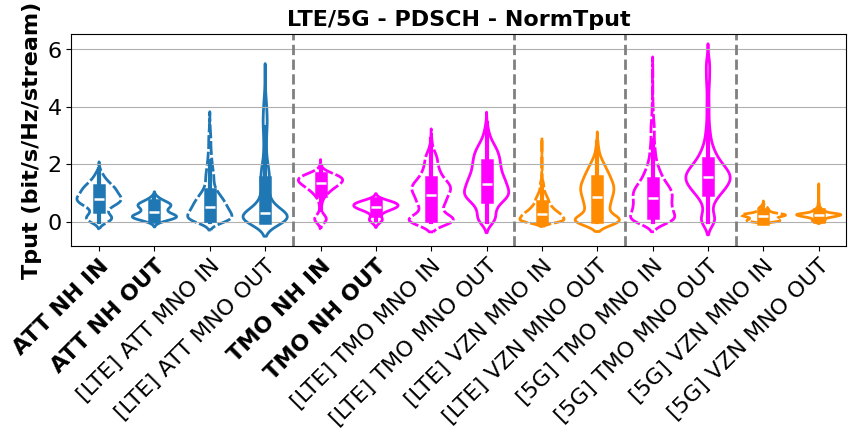

In [128]:
# LTE/5G - PDSCH - NormTput
fig, ax = plt.subplots(figsize=(10, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pdsch_att_nh_in.assign(Collection_plot='ATT NH IN'),
    df_lte_pdsch_att_nh_out.assign(Collection_plot='ATT NH OUT'),
    df_lte_pdsch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_pdsch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pdsch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_pdsch_tmo_nh_out.assign(Collection_plot='TMO NH OUT'),
    df_lte_pdsch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pdsch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_pdsch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_pdsch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pdsch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pdsch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_pdsch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_pdsch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='Normalized Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 14, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=3.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=7.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT NH IN', 'ATT NH OUT', 'TMO NH IN', 'TMO NH OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (bit/s/Hz/stream)', fontsize=16, fontweight='bold')
plt.title('LTE/5G - PDSCH - NormTput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, labels

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_22484/1341433707.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')


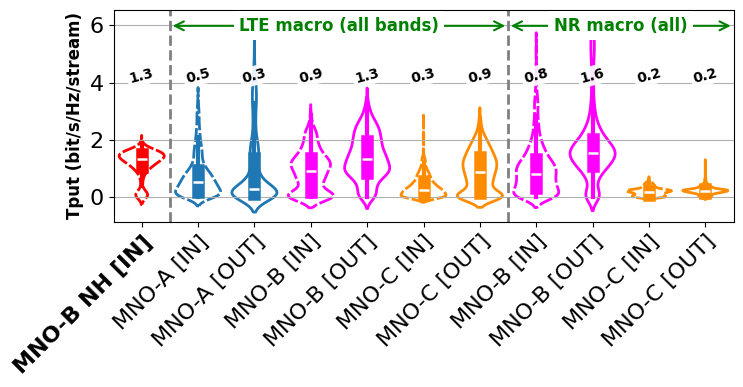

In [129]:
# LTE/5G - PDSCH - NormTput
fig, ax = plt.subplots(figsize=(8, 2.75))
palette = ['red', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pdsch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_pdsch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_pdsch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pdsch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pdsch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_pdsch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_pdsch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pdsch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pdsch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_pdsch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_pdsch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='Normalized Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
new_labels = ['MNO-B NH [IN]', 'MNO-A [IN]', 'MNO-A [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]']
ax.set_xticklabels(new_labels, rotation=45, ha='right')

ax.collections[0].set_linestyle((0,(5,1)))
ax.collections[1].set_linestyle((0,(5,1)))
ax.collections[3].set_linestyle((0,(5,1)))
ax.collections[5].set_linestyle((0,(5,1)))
ax.collections[7].set_linestyle((0,(5,1)))
ax.collections[9].set_linestyle((0,(5,1)))

plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=6.5, color='gray', linestyle='--', linewidth=2)

medians = data.groupby('Collection_plot')['Normalized Throughput'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 4, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

ax.annotate(
    '', xy=(6.5, 0.925), xytext=(0.5, 0.925),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(4/11, 0.925, 'LTE macro (all bands)', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.annotate(
    '', xy=(10.5, 0.925), xytext=(6.5, 0.925),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(9/11, 0.925, 'NR macro (all)', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['MNO-B NH [IN]']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (bit/s/Hz/stream)', fontsize=12, fontweight='bold')
# plt.title('LTE/5G - Radio - RSRP/SS-RSRP', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.ylim(0, 6.2)
# plt.savefig('figs/pdsch_all_normtput.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_22484/63834276.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')


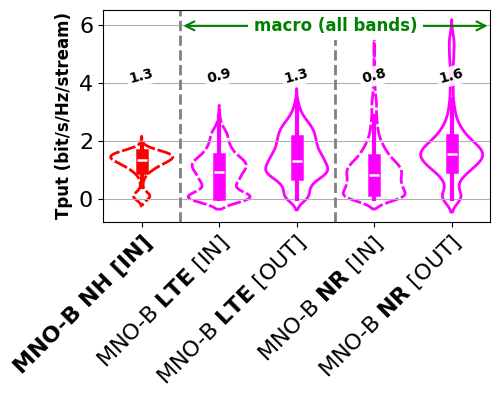

In [ ]:
# LTE/5G - PDSCH - NormTput
fig, ax = plt.subplots(figsize=(5, 2.75))
palette = ['red', 'magenta', 'magenta', 'magenta', 'magenta']
data = pd.concat([
    df_lte_pdsch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    # df_lte_pdsch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    # df_lte_pdsch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pdsch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pdsch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    # df_lte_pdsch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    # df_lte_pdsch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pdsch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pdsch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    # df_5g_pdsch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    # df_5g_pdsch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='Normalized Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
# new_labels = ['MNO-B NH [IN]', 'MNO-A [IN]', 'MNO-A [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]']
new_labels = ['MNO-B NH [IN]', r'MNO-B $\bf{LTE}$ [IN]', r'MNO-B $\bf{LTE}$ [OUT]', r'MNO-B $\bf{NR}$ [IN]', r'MNO-B $\bf{NR}$ [OUT]']
ax.set_xticklabels(new_labels, rotation=45, ha='right')

ax.collections[0].set_linestyle((0,(5,1)))
ax.collections[1].set_linestyle((0,(5,1)))
ax.collections[3].set_linestyle((0,(5,1)))
# ax.collections[5].set_linestyle((0,(5,1)))
# ax.collections[7].set_linestyle((0,(5,1)))
# ax.collections[9].set_linestyle((0,(5,1)))

plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=2)

medians = data.groupby('Collection_plot')['Normalized Throughput'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 4, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

ax.annotate(
    '', xy=(4.5, 0.925), xytext=(0.5, 0.925),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(3/5, 0.925, 'macro (all bands)', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

# ax.annotate(
#     '', xy=(10.5, 0.925), xytext=(6.5, 0.925),
#     xycoords=('data', 'axes fraction'),
#     textcoords=('data', 'axes fraction'),
#     arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
# )
# ax.text(9/11, 0.925, 'macro (all)', transform=ax.transAxes,
#         ha='center', va='center', fontsize=12, fontweight='bold', color='green',
#         bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()

for label in labels:
    if label.get_text() in ['MNO-B NH [IN]']:
        label.set_fontweight('bold')

plt.xlabel('')
plt.ylabel('Tput (bit/s/Hz/stream)', fontsize=12, fontweight='bold')
# plt.title('LTE/5G - Radio - RSRP/SS-RSRP', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.ylim(0, 6.2)
# plt.savefig('figs/pdsch_select_normtput.pdf', bbox_inches='tight')
plt.show()
# del fig, ax, dx, dy, offset, label, data, palette, labels

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_22484/2583107283.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')


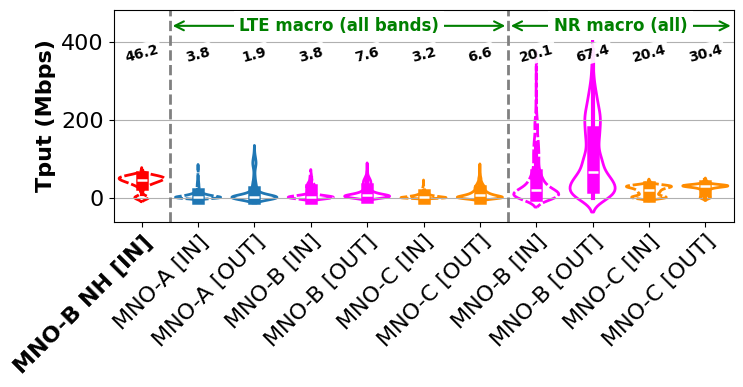

In [131]:
# LTE/5G - PDSCH - Tput
fig, ax = plt.subplots(figsize=(8, 2.75))
palette = ['red', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pdsch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_pdsch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_pdsch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pdsch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pdsch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_pdsch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_pdsch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pdsch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pdsch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_pdsch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_pdsch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='Net PDSCH Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
new_labels = ['MNO-B NH [IN]', 'MNO-A [IN]', 'MNO-A [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]']
ax.set_xticklabels(new_labels, rotation=45, ha='right')

ax.collections[0].set_linestyle((0,(5,1)))
ax.collections[1].set_linestyle((0,(5,1)))
ax.collections[3].set_linestyle((0,(5,1)))
ax.collections[5].set_linestyle((0,(5,1)))
ax.collections[7].set_linestyle((0,(5,1)))
ax.collections[9].set_linestyle((0,(5,1)))

plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=6.5, color='gray', linestyle='--', linewidth=2)

medians = data.groupby('Collection_plot')['Net PDSCH Throughput'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 3.5e5, f'{medians[collection]/1e3:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

ax.annotate(
    '', xy=(6.5, 0.925), xytext=(0.5, 0.925),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(4/11, 0.925, 'LTE macro (all bands)', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.annotate(
    '', xy=(10.5, 0.925), xytext=(6.5, 0.925),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(9/11, 0.925, 'NR macro (all)', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['MNO-B NH [IN]']:
        label.set_fontweight('bold')

plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
# plt.title('LTE/5G - Radio - RSRP/SS-RSRP', fontsize=16, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
plt.grid(True, axis='y')
# plt.ylim(0, 6.2)
# plt.savefig('figs/pdsch_all_tput.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

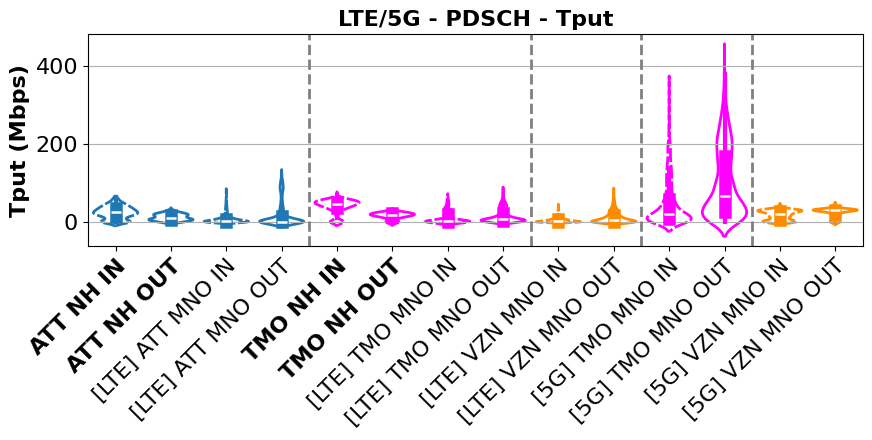

In [132]:
# LTE/5G - PDSCH - Tput
fig, ax = plt.subplots(figsize=(10, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pdsch_att_nh_in.assign(Collection_plot='ATT NH IN'),
    df_lte_pdsch_att_nh_out.assign(Collection_plot='ATT NH OUT'),
    df_lte_pdsch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_pdsch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pdsch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_pdsch_tmo_nh_out.assign(Collection_plot='TMO NH OUT'),
    df_lte_pdsch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pdsch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_pdsch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_pdsch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pdsch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pdsch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_pdsch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_pdsch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='Net PDSCH Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 14, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=3.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=7.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT NH IN', 'ATT NH OUT', 'TMO NH IN', 'TMO NH OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
plt.title('LTE/5G - PDSCH - Tput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, labels

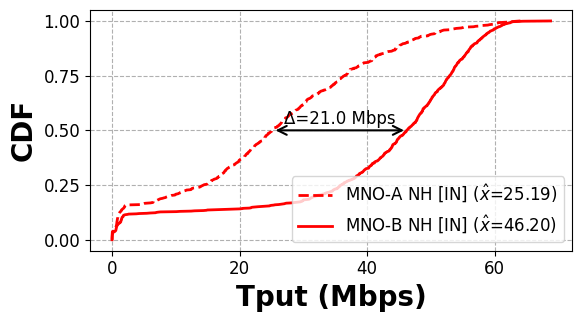

In [133]:
# NH - PDSCH - Tput
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.rcParams['text.usetex'] = False 

df_temp = data = df_lte_pdsch_att_nh_in['Net PDSCH Throughput'].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"MNO-A NH [IN] ($\hat{{x}}$={df_temp.median()/1e3:.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='red')
del df_temp

df_temp = data = df_lte_pdsch_tmo_nh_in['Net PDSCH Throughput'].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"MNO-B NH [IN] ($\hat{{x}}$={df_temp.median()/1e3:.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='red')
del df_temp

median_1 = df_lte_pdsch_att_nh_in['Net PDSCH Throughput'].dropna().median()
median_2 = df_lte_pdsch_tmo_nh_in['Net PDSCH Throughput'].dropna().median()
arrow_y = 0.5
ax.annotate(
    '', 
    xy=(median_1, arrow_y), 
    xytext=(median_2, arrow_y),
    arrowprops=dict(arrowstyle='<->', lw=1.5, color='black')
)
ax.text(
    (median_1 + median_2)/2, arrow_y + 0.03,
    f'Δ={abs(median_1 - median_2)/1e3:.1f} Mbps',
    ha='center', fontsize=12
)

ax.set_xlabel('Tput (Mbps)', fontsize=20, fontweight='bold')
ax.set_ylabel('CDF', fontsize=20, fontweight='bold')
# plt.title('Calculated Tput (MNO OUT - LTE Technology)', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
# plt.xlim(-160, -40)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1e3)}'))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
# plt.savefig('figs/pdsch_nh_tput.pdf', bbox_inches='tight')
plt.show()

del fig, ax, median_1, median_2, arrow_y

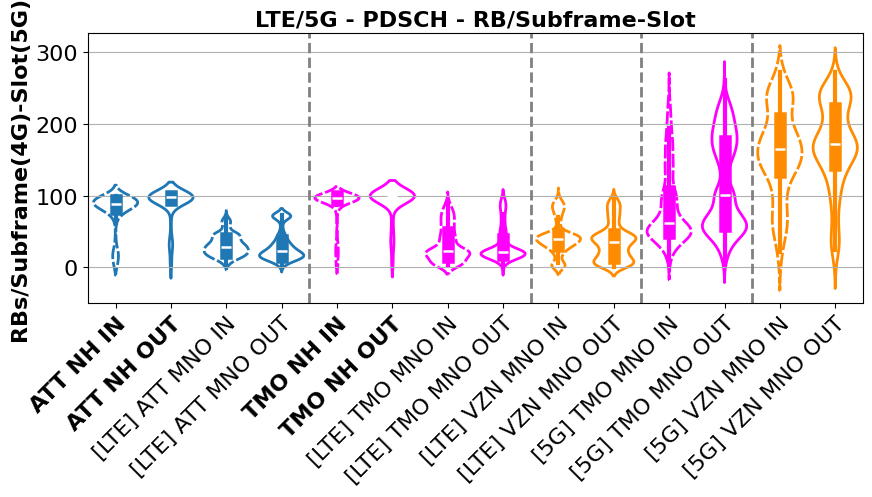

In [134]:
# LTE/5G - PDSCH - RB/Subframe-Slot
fig, ax = plt.subplots(figsize=(10, 3.5))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pdsch_att_nh_in.assign(Collection_plot='ATT NH IN'),
    df_lte_pdsch_att_nh_out.assign(Collection_plot='ATT NH OUT'),
    df_lte_pdsch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_pdsch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pdsch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_pdsch_tmo_nh_out.assign(Collection_plot='TMO NH OUT'),
    df_lte_pdsch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pdsch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_pdsch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_pdsch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pdsch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pdsch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_pdsch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_pdsch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='RB per Subframe-Slot', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 14, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=3.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=7.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT NH IN', 'ATT NH OUT', 'TMO NH IN', 'TMO NH OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RBs/Subframe(4G)-Slot(5G)', fontsize=16, fontweight='bold')
plt.title('LTE/5G - PDSCH - RB/Subframe-Slot', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, labels

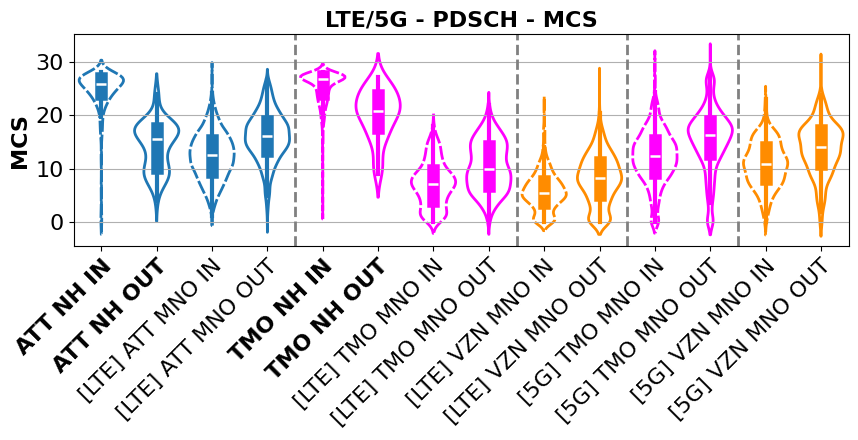

In [135]:
# LTE/5G - PDSCH - MCS
fig, ax = plt.subplots(figsize=(10, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pdsch_att_nh_in.assign(Collection_plot='ATT NH IN'),
    df_lte_pdsch_att_nh_out.assign(Collection_plot='ATT NH OUT'),
    df_lte_pdsch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_pdsch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pdsch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_pdsch_tmo_nh_out.assign(Collection_plot='TMO NH OUT'),
    df_lte_pdsch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pdsch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_pdsch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_pdsch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pdsch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pdsch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_pdsch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_pdsch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data.dropna(subset=['MCS']), x='Collection_plot', y='MCS', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 14, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=3.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=7.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT NH IN', 'ATT NH OUT', 'TMO NH IN', 'TMO NH OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('MCS', fontsize=16, fontweight='bold')
plt.title('LTE/5G - PDSCH - MCS', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, labels

##### Plots: NH - In vs Out

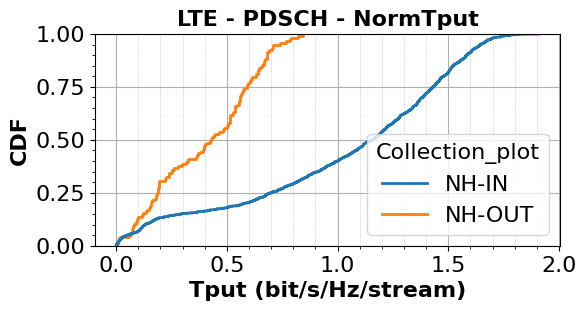

In [136]:
# LTE - PDSCH - NormTput
fig, ax = plt.subplots(figsize=(6, 2.75))
data = pd.concat([
    df_lte_pdsch_att_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_pdsch_att_nh_out.assign(Collection_plot='NH-OUT'),
    df_lte_pdsch_tmo_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_pdsch_tmo_nh_out.assign(Collection_plot='NH-OUT'),
])
sns.ecdfplot(data=data, x='Normalized Throughput', hue='Collection_plot', ax=ax, linewidth=2)
plt.ylabel('CDF', fontsize=16, fontweight='bold')
plt.xlabel('Tput (bit/s/Hz/stream)', fontsize=16, fontweight='bold')
plt.title('LTE - PDSCH - NormTput', fontsize=16, fontweight='bold')
plt.grid(True)
ax.minorticks_on()
ax.xaxis.grid(True, which='minor', linestyle=':', linewidth=0.5)
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, data

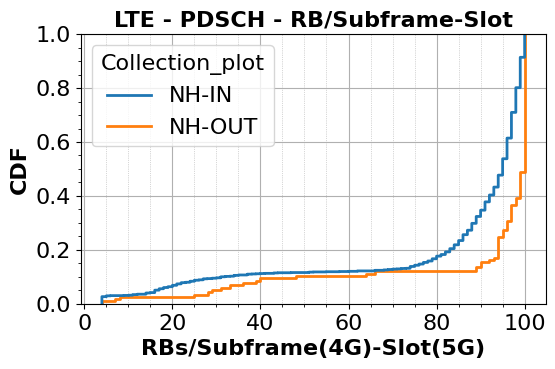

In [137]:
# LTE - PDSCH - RB/Subframe-Slot
fig, ax = plt.subplots(figsize=(6, 3.5))
data = pd.concat([
    df_lte_pdsch_att_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_pdsch_att_nh_out.assign(Collection_plot='NH-OUT'),
    df_lte_pdsch_tmo_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_pdsch_tmo_nh_out.assign(Collection_plot='NH-OUT'),
])
sns.ecdfplot(data=data, x='RB per Subframe-Slot', hue='Collection_plot', ax=ax, linewidth=2)
plt.ylabel('CDF', fontsize=16, fontweight='bold')
plt.xlabel('RBs/Subframe(4G)-Slot(5G)', fontsize=16, fontweight='bold')
plt.title('LTE - PDSCH - RB/Subframe-Slot', fontsize=16, fontweight='bold')
plt.grid(True)
ax.minorticks_on()
ax.xaxis.grid(True, which='minor', linestyle=':', linewidth=0.5)
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, data

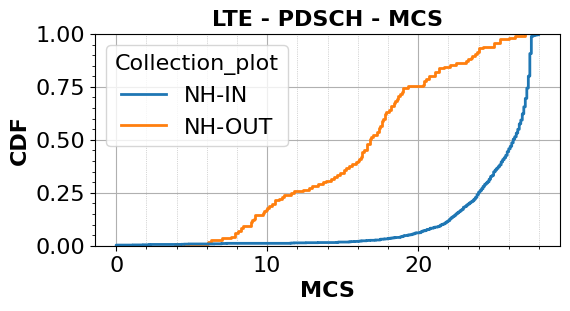

In [138]:
# LTE - PDSCH - MCS
fig, ax = plt.subplots(figsize=(6, 2.75))
data = pd.concat([
    df_lte_pdsch_att_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_pdsch_att_nh_out.assign(Collection_plot='NH-OUT'),
    df_lte_pdsch_tmo_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_pdsch_tmo_nh_out.assign(Collection_plot='NH-OUT'),
])
sns.ecdfplot(data=data, x='MCS', hue='Collection_plot', ax=ax, linewidth=2)
plt.ylabel('CDF', fontsize=16, fontweight='bold')
plt.xlabel('MCS', fontsize=16, fontweight='bold')
plt.title('LTE - PDSCH - MCS', fontsize=16, fontweight='bold')
plt.grid(True)
ax.minorticks_on()
ax.xaxis.grid(True, which='minor', linestyle=':', linewidth=0.5)
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, data

##### Plots: Band specific

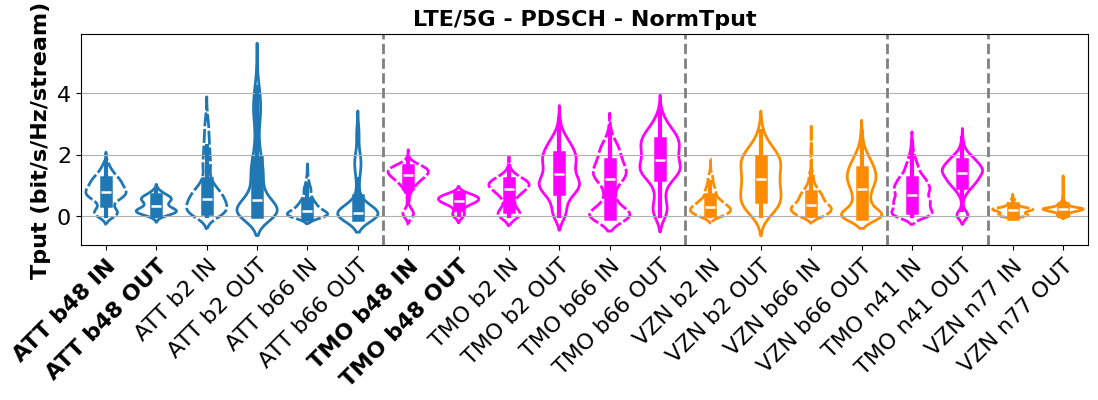

In [139]:
# LTE/5G - PDSCH - NormTput
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pdsch_att_nh_in.assign(Collection_plot='ATT b48 IN'),
    df_lte_pdsch_att_nh_out.assign(Collection_plot='ATT b48 OUT'),
    df_lte_pdsch_att_mno_in[df_lte_pdsch_att_mno_in['Band Number']==2].assign(Collection_plot='ATT b2 IN'),
    df_lte_pdsch_att_mno_out[df_lte_pdsch_att_mno_out['Band Number']==2].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pdsch_att_mno_in[df_lte_pdsch_att_mno_in['Band Number']==66].assign(Collection_plot='ATT b66 IN'),
    df_lte_pdsch_att_mno_out[df_lte_pdsch_att_mno_out['Band Number']==66].assign(Collection_plot='ATT b66 OUT'),
    df_lte_pdsch_tmo_nh_in.assign(Collection_plot='TMO b48 IN'),
    df_lte_pdsch_tmo_nh_out.assign(Collection_plot='TMO b48 OUT'),
    df_lte_pdsch_tmo_mno_in[df_lte_pdsch_tmo_mno_in['Band Number']==2].assign(Collection_plot='TMO b2 IN'),
    df_lte_pdsch_tmo_mno_out[df_lte_pdsch_tmo_mno_out['Band Number']==2].assign(Collection_plot='TMO b2 OUT'),
    df_lte_pdsch_tmo_mno_in[df_lte_pdsch_tmo_mno_in['Band Number']==66].assign(Collection_plot='TMO b66 IN'),
    df_lte_pdsch_tmo_mno_out[df_lte_pdsch_tmo_mno_out['Band Number']==66].assign(Collection_plot='TMO b66 OUT'),
    df_lte_pdsch_vzn_mno_in[df_lte_pdsch_vzn_mno_in['Band Number']==2].assign(Collection_plot='VZN b2 IN'),
    df_lte_pdsch_vzn_mno_out[df_lte_pdsch_vzn_mno_out['Band Number']==2].assign(Collection_plot='VZN b2 OUT'),
    df_lte_pdsch_vzn_mno_in[df_lte_pdsch_vzn_mno_in['Band Number']==66].assign(Collection_plot='VZN b66 IN'),
    df_lte_pdsch_vzn_mno_out[df_lte_pdsch_vzn_mno_out['Band Number']==66].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pdsch_tmo_mno_in[df_5g_pdsch_tmo_mno_in['Band Number']==41].assign(Collection_plot='TMO n41 IN'),
    df_5g_pdsch_tmo_mno_out[df_5g_pdsch_tmo_mno_out['Band Number']==41].assign(Collection_plot='TMO n41 OUT'),
    df_5g_pdsch_vzn_mno_in[df_5g_pdsch_vzn_mno_in['Band Number']==77].assign(Collection_plot='VZN n77 IN'),
    df_5g_pdsch_vzn_mno_out[df_5g_pdsch_vzn_mno_out['Band Number']==77].assign(Collection_plot='VZN n77 OUT'),
])
sns.violinplot(data=data, x='Collection_plot', y='Normalized Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 20, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=17.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (bit/s/Hz/stream)', fontsize=16, fontweight='bold')
plt.title('LTE/5G - PDSCH - NormTput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

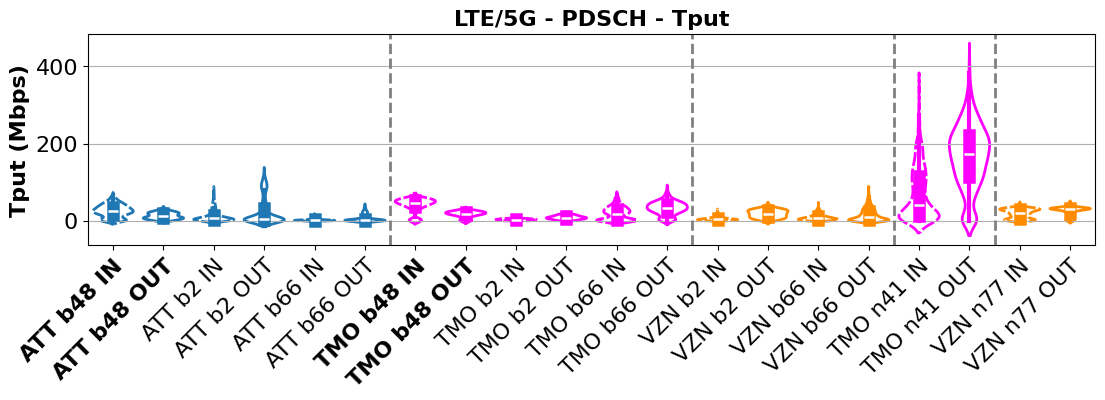

In [140]:
# LTE/5G - PDSCH - Tput
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pdsch_att_nh_in.assign(Collection_plot='ATT b48 IN'),
    df_lte_pdsch_att_nh_out.assign(Collection_plot='ATT b48 OUT'),
    df_lte_pdsch_att_mno_in[df_lte_pdsch_att_mno_in['Band Number']==2].assign(Collection_plot='ATT b2 IN'),
    df_lte_pdsch_att_mno_out[df_lte_pdsch_att_mno_out['Band Number']==2].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pdsch_att_mno_in[df_lte_pdsch_att_mno_in['Band Number']==66].assign(Collection_plot='ATT b66 IN'),
    df_lte_pdsch_att_mno_out[df_lte_pdsch_att_mno_out['Band Number']==66].assign(Collection_plot='ATT b66 OUT'),
    df_lte_pdsch_tmo_nh_in.assign(Collection_plot='TMO b48 IN'),
    df_lte_pdsch_tmo_nh_out.assign(Collection_plot='TMO b48 OUT'),
    df_lte_pdsch_tmo_mno_in[df_lte_pdsch_tmo_mno_in['Band Number']==2].assign(Collection_plot='TMO b2 IN'),
    df_lte_pdsch_tmo_mno_out[df_lte_pdsch_tmo_mno_out['Band Number']==2].assign(Collection_plot='TMO b2 OUT'),
    df_lte_pdsch_tmo_mno_in[df_lte_pdsch_tmo_mno_in['Band Number']==66].assign(Collection_plot='TMO b66 IN'),
    df_lte_pdsch_tmo_mno_out[df_lte_pdsch_tmo_mno_out['Band Number']==66].assign(Collection_plot='TMO b66 OUT'),
    df_lte_pdsch_vzn_mno_in[df_lte_pdsch_vzn_mno_in['Band Number']==2].assign(Collection_plot='VZN b2 IN'),
    df_lte_pdsch_vzn_mno_out[df_lte_pdsch_vzn_mno_out['Band Number']==2].assign(Collection_plot='VZN b2 OUT'),
    df_lte_pdsch_vzn_mno_in[df_lte_pdsch_vzn_mno_in['Band Number']==66].assign(Collection_plot='VZN b66 IN'),
    df_lte_pdsch_vzn_mno_out[df_lte_pdsch_vzn_mno_out['Band Number']==66].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pdsch_tmo_mno_in[df_5g_pdsch_tmo_mno_in['Band Number']==41].assign(Collection_plot='TMO n41 IN'),
    df_5g_pdsch_tmo_mno_out[df_5g_pdsch_tmo_mno_out['Band Number']==41].assign(Collection_plot='TMO n41 OUT'),
    df_5g_pdsch_vzn_mno_in[df_5g_pdsch_vzn_mno_in['Band Number']==77].assign(Collection_plot='VZN n77 IN'),
    df_5g_pdsch_vzn_mno_out[df_5g_pdsch_vzn_mno_out['Band Number']==77].assign(Collection_plot='VZN n77 OUT'),
])
sns.violinplot(data=data, x='Collection_plot', y='Net PDSCH Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 20, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=17.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
plt.title('LTE/5G - PDSCH - Tput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

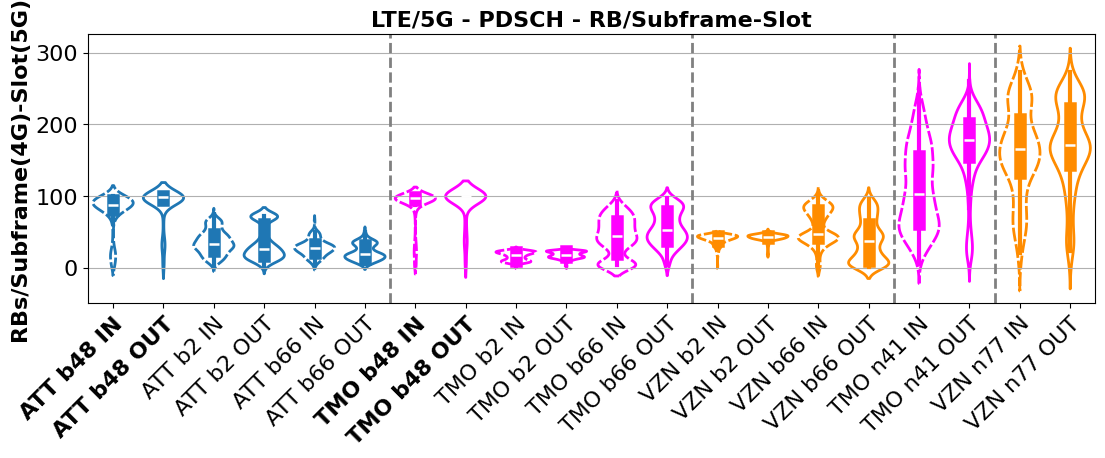

In [141]:
# LTE/5G - PDSCH - RB/Subframe-Slot
fig, ax = plt.subplots(figsize=(13, 3.5))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pdsch_att_nh_in.assign(Collection_plot='ATT b48 IN'),
    df_lte_pdsch_att_nh_out.assign(Collection_plot='ATT b48 OUT'),
    df_lte_pdsch_att_mno_in[df_lte_pdsch_att_mno_in['Band Number']==2].assign(Collection_plot='ATT b2 IN'),
    df_lte_pdsch_att_mno_out[df_lte_pdsch_att_mno_out['Band Number']==2].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pdsch_att_mno_in[df_lte_pdsch_att_mno_in['Band Number']==66].assign(Collection_plot='ATT b66 IN'),
    df_lte_pdsch_att_mno_out[df_lte_pdsch_att_mno_out['Band Number']==66].assign(Collection_plot='ATT b66 OUT'),
    df_lte_pdsch_tmo_nh_in.assign(Collection_plot='TMO b48 IN'),
    df_lte_pdsch_tmo_nh_out.assign(Collection_plot='TMO b48 OUT'),
    df_lte_pdsch_tmo_mno_in[df_lte_pdsch_tmo_mno_in['Band Number']==2].assign(Collection_plot='TMO b2 IN'),
    df_lte_pdsch_tmo_mno_out[df_lte_pdsch_tmo_mno_out['Band Number']==2].assign(Collection_plot='TMO b2 OUT'),
    df_lte_pdsch_tmo_mno_in[df_lte_pdsch_tmo_mno_in['Band Number']==66].assign(Collection_plot='TMO b66 IN'),
    df_lte_pdsch_tmo_mno_out[df_lte_pdsch_tmo_mno_out['Band Number']==66].assign(Collection_plot='TMO b66 OUT'),
    df_lte_pdsch_vzn_mno_in[df_lte_pdsch_vzn_mno_in['Band Number']==2].assign(Collection_plot='VZN b2 IN'),
    df_lte_pdsch_vzn_mno_out[df_lte_pdsch_vzn_mno_out['Band Number']==2].assign(Collection_plot='VZN b2 OUT'),
    df_lte_pdsch_vzn_mno_in[df_lte_pdsch_vzn_mno_in['Band Number']==66].assign(Collection_plot='VZN b66 IN'),
    df_lte_pdsch_vzn_mno_out[df_lte_pdsch_vzn_mno_out['Band Number']==66].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pdsch_tmo_mno_in[df_5g_pdsch_tmo_mno_in['Band Number']==41].assign(Collection_plot='TMO n41 IN'),
    df_5g_pdsch_tmo_mno_out[df_5g_pdsch_tmo_mno_out['Band Number']==41].assign(Collection_plot='TMO n41 OUT'),
    df_5g_pdsch_vzn_mno_in[df_5g_pdsch_vzn_mno_in['Band Number']==77].assign(Collection_plot='VZN n77 IN'),
    df_5g_pdsch_vzn_mno_out[df_5g_pdsch_vzn_mno_out['Band Number']==77].assign(Collection_plot='VZN n77 OUT'),
])
sns.violinplot(data=data, x='Collection_plot', y='RB per Subframe-Slot', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 20, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=17.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RBs/Subframe(4G)-Slot(5G)', fontsize=16, fontweight='bold')
plt.title('LTE/5G - PDSCH - RB/Subframe-Slot', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

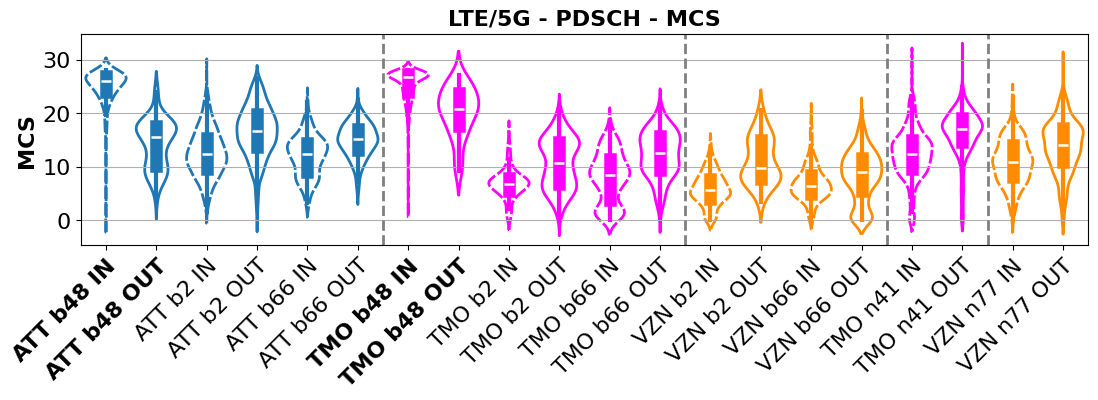

In [142]:
# LTE/5G - PDSCH - MCS
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pdsch_att_nh_in.assign(Collection_plot='ATT b48 IN'),
    df_lte_pdsch_att_nh_out.assign(Collection_plot='ATT b48 OUT'),
    df_lte_pdsch_att_mno_in[df_lte_pdsch_att_mno_in['Band Number']==2].assign(Collection_plot='ATT b2 IN'),
    df_lte_pdsch_att_mno_out[df_lte_pdsch_att_mno_out['Band Number']==2].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pdsch_att_mno_in[df_lte_pdsch_att_mno_in['Band Number']==66].assign(Collection_plot='ATT b66 IN'),
    df_lte_pdsch_att_mno_out[df_lte_pdsch_att_mno_out['Band Number']==66].assign(Collection_plot='ATT b66 OUT'),
    df_lte_pdsch_tmo_nh_in.assign(Collection_plot='TMO b48 IN'),
    df_lte_pdsch_tmo_nh_out.assign(Collection_plot='TMO b48 OUT'),
    df_lte_pdsch_tmo_mno_in[df_lte_pdsch_tmo_mno_in['Band Number']==2].assign(Collection_plot='TMO b2 IN'),
    df_lte_pdsch_tmo_mno_out[df_lte_pdsch_tmo_mno_out['Band Number']==2].assign(Collection_plot='TMO b2 OUT'),
    df_lte_pdsch_tmo_mno_in[df_lte_pdsch_tmo_mno_in['Band Number']==66].assign(Collection_plot='TMO b66 IN'),
    df_lte_pdsch_tmo_mno_out[df_lte_pdsch_tmo_mno_out['Band Number']==66].assign(Collection_plot='TMO b66 OUT'),
    df_lte_pdsch_vzn_mno_in[df_lte_pdsch_vzn_mno_in['Band Number']==2].assign(Collection_plot='VZN b2 IN'),
    df_lte_pdsch_vzn_mno_out[df_lte_pdsch_vzn_mno_out['Band Number']==2].assign(Collection_plot='VZN b2 OUT'),
    df_lte_pdsch_vzn_mno_in[df_lte_pdsch_vzn_mno_in['Band Number']==66].assign(Collection_plot='VZN b66 IN'),
    df_lte_pdsch_vzn_mno_out[df_lte_pdsch_vzn_mno_out['Band Number']==66].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pdsch_tmo_mno_in[df_5g_pdsch_tmo_mno_in['Band Number']==41].assign(Collection_plot='TMO n41 IN'),
    df_5g_pdsch_tmo_mno_out[df_5g_pdsch_tmo_mno_out['Band Number']==41].assign(Collection_plot='TMO n41 OUT'),
    df_5g_pdsch_vzn_mno_in[df_5g_pdsch_vzn_mno_in['Band Number']==77].assign(Collection_plot='VZN n77 IN'),
    df_5g_pdsch_vzn_mno_out[df_5g_pdsch_vzn_mno_out['Band Number']==77].assign(Collection_plot='VZN n77 OUT'),
])
sns.violinplot(data=data.dropna(subset='MCS'), x='Collection_plot', y='MCS', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 20, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=17.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('MCS', fontsize=16, fontweight='bold')
plt.title('LTE/5G - PDSCH - MCS', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

##### print(): PCI statistics

Summary of Representative PCIs:

NH IN - AP 1 - PCI 4,7

NH OUT - AP 6 - PCI 8,15

ATT b2,66 - PCI 77

TMO b2 - PCI 231

TMO b66 - PCI 294

VZN b2,66 - PCI 357

TMO n41 - PCI 681

VZN n77 - PCI 357

In [143]:
print('LTE ATT NH IN')
print(df_lte_pdsch_att_nh_in[['Band Number', 'PCI']].value_counts().sort_index())
print('LTE ATT NH OUT')
print(df_lte_pdsch_att_nh_out[['Band Number', 'PCI']].value_counts().sort_index())
print('LTE ATT MNO IN')
print(df_lte_pdsch_att_mno_in[['Band Number', 'PCI']].value_counts().sort_index())
print('LTE ATT MNO OUT')
print(df_lte_pdsch_att_mno_out[['Band Number', 'PCI']].value_counts().sort_index())

LTE ATT NH IN
Band Number  PCI 
48.0         4.0     67
             5.0     34
             7.0     57
             8.0     43
             9.0     17
             13.0    89
             15.0    38
             16.0    78
             20.0    23
             21.0    17
             23.0    44
             25.0    22
Name: count, dtype: int64
LTE ATT NH OUT
Band Number  PCI
48.0         4.0    34
             7.0    44
Name: count, dtype: int64
LTE ATT MNO IN
Band Number  PCI  
2.0          77.0     517
             80.0      43
             422.0    162
             430.0    403
12.0         77.0     289
             81.0      68
             422.0     10
14.0         77.0      43
             80.0      38
             81.0      67
             422.0     15
30.0         77.0     382
             422.0      2
66.0         77.0     138
             80.0       8
             422.0     14
Name: count, dtype: int64
LTE ATT MNO OUT
Band Number  PCI  
2.0          77.0     505
             

In [144]:
print('LTE TMO NH IN')
print(df_lte_pdsch_tmo_nh_in[['Band Number', 'PCI']].value_counts().sort_index())
print('LTE TMO NH OUT')
print(df_lte_pdsch_tmo_nh_out[['Band Number', 'PCI']].value_counts().sort_index())
print('LTE TMO MNO IN')
print(df_lte_pdsch_tmo_mno_in[['Band Number', 'PCI']].value_counts().sort_index())
print('LTE TMO MNO OUT')
print(df_lte_pdsch_tmo_mno_out[['Band Number', 'PCI']].value_counts().sort_index())

LTE TMO NH IN
Band Number  PCI 
48.0         4.0     155
             5.0      88
             7.0     122
             8.0      44
             9.0      21
             13.0     93
             15.0     40
             16.0     70
             20.0     18
             21.0     17
             23.0    113
             25.0     21
Name: count, dtype: int64
LTE TMO NH OUT
Band Number  PCI
48.0         4.0    22
             7.0    17
Name: count, dtype: int64
LTE TMO MNO IN
Band Number  PCI  
2.0          231.0    147
             462.0     70
12.0         252.0    114
             306.0     68
66.0         294.0    263
             330.0    275
Name: count, dtype: int64
LTE TMO MNO OUT
Band Number  PCI  
2.0          231.0    141
             462.0    194
             494.0      9
12.0         252.0    133
             306.0    192
66.0         294.0    209
             311.0     10
             330.0    150
Name: count, dtype: int64


In [145]:
print('LTE VZN MNO IN')
print(df_lte_pdsch_vzn_mno_in[['Band Number', 'PCI']].value_counts().sort_index())
print('LTE VZN MNO OUT')
print(df_lte_pdsch_vzn_mno_out[['Band Number', 'PCI']].value_counts().sort_index())

LTE VZN MNO IN
Band Number  PCI  
2.0          155.0     11
             357.0    332
5.0          357.0    222
13.0         125.0    140
             155.0     23
             357.0    176
66.0         125.0     24
             155.0      9
             357.0    692
Name: count, dtype: int64
LTE VZN MNO OUT
Band Number  PCI  
2.0          357.0     58
13.0         125.0    207
             357.0     59
66.0         125.0    375
             357.0    324
Name: count, dtype: int64


In [146]:
print('5G TMO MNO IN')
print(df_5g_pdsch_tmo_mno_in[['Band Number', 'PCI']].value_counts().sort_index())
print('5G TMO MNO OUT')
print(df_5g_pdsch_tmo_mno_out[['Band Number', 'PCI']].value_counts().sort_index())
print('5G VZN MNO IN')
print(df_5g_pdsch_vzn_mno_in[['Band Number', 'PCI']].value_counts().sort_index())
print('5G VZN MNO OUT')
print(df_5g_pdsch_vzn_mno_out[['Band Number', 'PCI']].value_counts().sort_index())

5G TMO MNO IN
Band Number  PCI  
25.0         447.0      69
             585.0     936
41.0         681.0    1359
71.0         24.0      236
Name: count, dtype: int64
5G TMO MNO OUT
Band Number  PCI  
25.0         447.0     162
             585.0     883
41.0         681.0    1372
71.0         24.0      445
Name: count, dtype: int64
5G VZN MNO IN
Band Number  PCI  
77.0         357.0    460
Name: count, dtype: int64
5G VZN MNO OUT
Band Number  PCI  
77.0         357.0    631
Name: count, dtype: int64


##### Plots: PCI specific

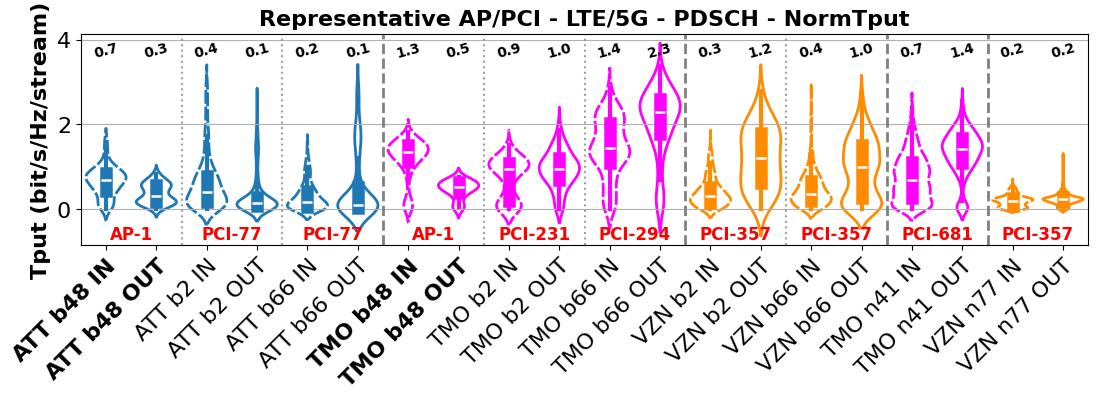

In [147]:
# LTE/5G - PDSCH - NormTput
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pdsch_att_nh_in[df_lte_pdsch_att_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 IN'),
    df_lte_pdsch_att_nh_out[df_lte_pdsch_att_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 OUT'),
    df_lte_pdsch_att_mno_in[(df_lte_pdsch_att_mno_in['Band Number'] == 2) & (df_lte_pdsch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b2 IN'),
    df_lte_pdsch_att_mno_out[(df_lte_pdsch_att_mno_out['Band Number'] == 2) & (df_lte_pdsch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pdsch_att_mno_in[(df_lte_pdsch_att_mno_in['Band Number'] == 66) & (df_lte_pdsch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b66 IN'),
    df_lte_pdsch_att_mno_out[(df_lte_pdsch_att_mno_out['Band Number'] == 66) & (df_lte_pdsch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b66 OUT'),
    df_lte_pdsch_tmo_nh_in[df_lte_pdsch_tmo_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 IN'),
    df_lte_pdsch_tmo_nh_out[df_lte_pdsch_tmo_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 OUT'),
    df_lte_pdsch_tmo_mno_in[(df_lte_pdsch_tmo_mno_in['Band Number']==2) & (df_lte_pdsch_tmo_mno_in['PCI'] == 231)].assign(Collection_plot='TMO b2 IN'),
    df_lte_pdsch_tmo_mno_out[(df_lte_pdsch_tmo_mno_out['Band Number']==2) & (df_lte_pdsch_tmo_mno_out['PCI'] == 231)].assign(Collection_plot='TMO b2 OUT'),
    df_lte_pdsch_tmo_mno_in[(df_lte_pdsch_tmo_mno_in['Band Number']==66) & (df_lte_pdsch_tmo_mno_in['PCI'] == 294)].assign(Collection_plot='TMO b66 IN'),
    df_lte_pdsch_tmo_mno_out[(df_lte_pdsch_tmo_mno_out['Band Number']==66) & (df_lte_pdsch_tmo_mno_out['PCI'] == 294)].assign(Collection_plot='TMO b66 OUT'),
    df_lte_pdsch_vzn_mno_in[(df_lte_pdsch_vzn_mno_in['Band Number'] == 2) & (df_lte_pdsch_vzn_mno_in['PCI'] == 357)].assign(Collection_plot='VZN b2 IN'),
    df_lte_pdsch_vzn_mno_out[(df_lte_pdsch_vzn_mno_out['Band Number'] == 2) & (df_lte_pdsch_vzn_mno_out['PCI'] == 357)].assign(Collection_plot='VZN b2 OUT'),
    df_lte_pdsch_vzn_mno_in[(df_lte_pdsch_vzn_mno_in['Band Number'] == 66) & (df_lte_pdsch_vzn_mno_in['PCI'] == 357)].assign(Collection_plot='VZN b66 IN'),
    df_lte_pdsch_vzn_mno_out[(df_lte_pdsch_vzn_mno_out['Band Number'] == 66) & (df_lte_pdsch_vzn_mno_out['PCI'] == 357)].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pdsch_tmo_mno_in[(df_5g_pdsch_tmo_mno_in['Band Number']==41) & (df_5g_pdsch_tmo_mno_in['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 IN'),
    df_5g_pdsch_tmo_mno_out[(df_5g_pdsch_tmo_mno_out['Band Number']==41) & (df_5g_pdsch_tmo_mno_out['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 OUT'),
    df_5g_pdsch_vzn_mno_in[(df_5g_pdsch_vzn_mno_in['Band Number']==77) & (df_5g_pdsch_vzn_mno_in['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 IN'),
    df_5g_pdsch_vzn_mno_out[(df_5g_pdsch_vzn_mno_out['Band Number']==77) & (df_5g_pdsch_vzn_mno_out['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='Normalized Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 20, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=17.5, color='gray', linestyle='--', linewidth=2)

plt.axvline(x=1.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=3.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=7.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=9.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=13.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
ax.text(0.05, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.15, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.25, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.35, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.45, 0.05, 'PCI-231', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.55, 0.05, 'PCI-294', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.65, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.75, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.85, 0.05, 'PCI-681', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.95, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
medians = data.groupby('Collection_plot')['Normalized Throughput'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 3.6, f'{median_value:.1f}', horizontalalignment='center', color='black', fontsize=10, fontweight='bold', rotation=15)

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (bit/s/Hz/stream)', fontsize=16, fontweight='bold')
plt.title('Representative AP/PCI - LTE/5G - PDSCH - NormTput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_22484/1603716929.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')


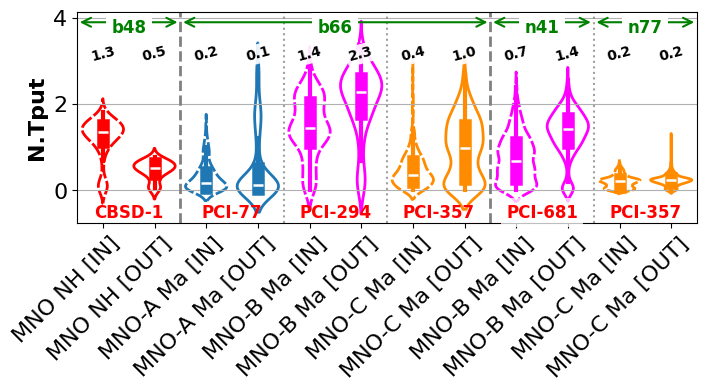

In [148]:
fig, ax = plt.subplots(figsize=(8, 2.75))
palette = ['red', 'red', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pdsch_tmo_nh_in[df_lte_pdsch_tmo_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='NH b48 [IN]'),
    df_lte_pdsch_tmo_nh_out[df_lte_pdsch_tmo_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='NH b48 [OUT]'),
    df_lte_pdsch_att_mno_in[(df_lte_pdsch_att_mno_in['Band Number'] == 66) & (df_lte_pdsch_att_mno_in['PCI'] == 77)].assign(Collection_plot='MNO-A b66 [IN]'),
    df_lte_pdsch_att_mno_out[(df_lte_pdsch_att_mno_out['Band Number'] == 66) & (df_lte_pdsch_att_mno_out['PCI'] == 77)].assign(Collection_plot='MNO-A b66 [OUT]'),
    df_lte_pdsch_tmo_mno_in[(df_lte_pdsch_tmo_mno_in['Band Number']==66) & (df_lte_pdsch_tmo_mno_in['PCI'] == 294)].assign(Collection_plot='MNO-B b66 [IN]'),
    df_lte_pdsch_tmo_mno_out[(df_lte_pdsch_tmo_mno_out['Band Number']==66) & (df_lte_pdsch_tmo_mno_out['PCI'] == 294)].assign(Collection_plot='MNO-B b66 [OUT]'),
    df_lte_pdsch_vzn_mno_in[(df_lte_pdsch_vzn_mno_in['Band Number'] == 66) & (df_lte_pdsch_vzn_mno_in['PCI'] == 357)].assign(Collection_plot='MNO-C b66 [IN]'),
    df_lte_pdsch_vzn_mno_out[(df_lte_pdsch_vzn_mno_out['Band Number'] == 66) & (df_lte_pdsch_vzn_mno_out['PCI'] == 357)].assign(Collection_plot='MNO-C b66 [OUT]'),
    df_5g_pdsch_tmo_mno_in[(df_5g_pdsch_tmo_mno_in['Band Number']==41) & (df_5g_pdsch_tmo_mno_in['PCI']==681)].assign(Collection_plot='MNO-B n41 [IN]'),
    df_5g_pdsch_tmo_mno_out[(df_5g_pdsch_tmo_mno_out['Band Number']==41) & (df_5g_pdsch_tmo_mno_out['PCI']==681)].assign(Collection_plot='MNO-B n41 [OUT]'),
    df_5g_pdsch_vzn_mno_in[(df_5g_pdsch_vzn_mno_in['Band Number']==77) & (df_5g_pdsch_vzn_mno_in['PCI']==357)].assign(Collection_plot='MNO-C n77 [IN]'),
    df_5g_pdsch_vzn_mno_out[(df_5g_pdsch_vzn_mno_out['Band Number']==77) & (df_5g_pdsch_vzn_mno_out['PCI']==357)].assign(Collection_plot='MNO-C n77 [OUT]')
])
sns.violinplot(data=data, x='Collection_plot', y='Normalized Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)

new_labels = ['MNO NH [IN]', 'MNO NH [OUT]','MNO-A Ma [IN]', 'MNO-A Ma [OUT]', 'MNO-B Ma [IN]', 'MNO-B Ma [OUT]', 'MNO-C Ma [IN]', 'MNO-C Ma [OUT]', 'MNO-B Ma [IN]', 'MNO-B Ma [OUT]', 'MNO-C Ma [IN]', 'MNO-C Ma [OUT]']
ax.set_xticklabels(new_labels, rotation=45, ha='right')

for i in range(0, 12, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines

medians = data.groupby('Collection_plot')['Normalized Throughput'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 3, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

plt.axvline(x=1.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=7.5, color='gray', linestyle='--', linewidth=2)

plt.axvline(x=3.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=5.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=9.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)

ax.text(1/12, 0.05, 'CBSD-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(1/12+2/12, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(1/12+4/12, 0.05, 'PCI-294', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(1/12+6/12, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(1/12+8/12, 0.05, 'PCI-681', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.75))
ax.text(1/12+10/12, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')

plt.xticks(rotation=45, ha='right')
dx = 15 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)

ax.annotate(
    '', xy=(-0.5, 0.95), xytext=(1.5, 0.95),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(1/12, 0.925, 'b48', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.annotate(
    '', xy=(1.5, 0.95), xytext=(7.5, 0.95),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(5/12, 0.925, 'b66', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.annotate(
    '', xy=(7.5, 0.95), xytext=(9.5, 0.95),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(9/12, 0.925, 'n41', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.annotate(
    '', xy=(9.5, 0.95), xytext=(11.5, 0.95),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(11/12, 0.925, 'n77', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['NH b48 [IN]', 'NH b48 [OUT]']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('N.Tput', fontsize=16, fontweight='bold')
# plt.title('Representative AP/PCI - LTE/5G - Radio - RSRP/SS-RSRP', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/pdsch_pci_normtput.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

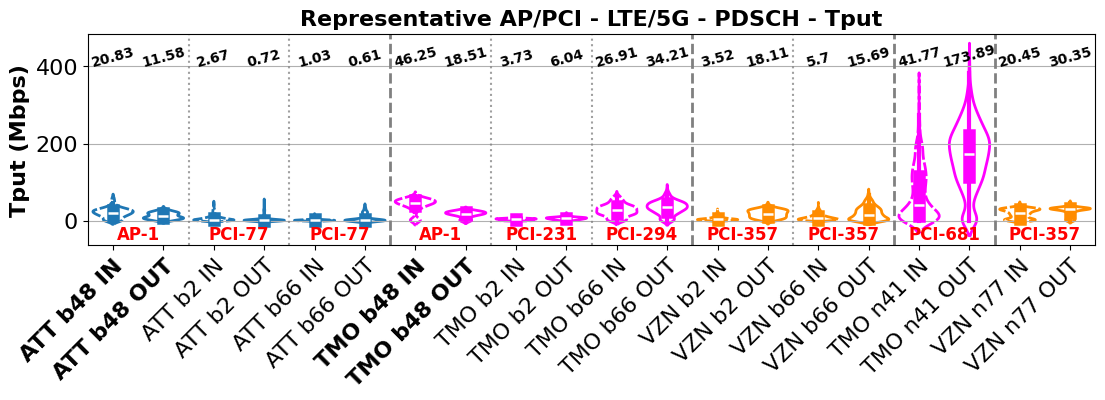

In [149]:
# LTE/5G - PDSCH - Tput
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pdsch_att_nh_in[df_lte_pdsch_att_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 IN'),
    df_lte_pdsch_att_nh_out[df_lte_pdsch_att_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 OUT'),
    df_lte_pdsch_att_mno_in[(df_lte_pdsch_att_mno_in['Band Number'] == 2) & (df_lte_pdsch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b2 IN'),
    df_lte_pdsch_att_mno_out[(df_lte_pdsch_att_mno_out['Band Number'] == 2) & (df_lte_pdsch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pdsch_att_mno_in[(df_lte_pdsch_att_mno_in['Band Number'] == 66) & (df_lte_pdsch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b66 IN'),
    df_lte_pdsch_att_mno_out[(df_lte_pdsch_att_mno_out['Band Number'] == 66) & (df_lte_pdsch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b66 OUT'),
    df_lte_pdsch_tmo_nh_in[df_lte_pdsch_tmo_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 IN'),
    df_lte_pdsch_tmo_nh_out[df_lte_pdsch_tmo_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 OUT'),
    df_lte_pdsch_tmo_mno_in[(df_lte_pdsch_tmo_mno_in['Band Number']==2) & (df_lte_pdsch_tmo_mno_in['PCI'] == 231)].assign(Collection_plot='TMO b2 IN'),
    df_lte_pdsch_tmo_mno_out[(df_lte_pdsch_tmo_mno_out['Band Number']==2) & (df_lte_pdsch_tmo_mno_out['PCI'] == 231)].assign(Collection_plot='TMO b2 OUT'),
    df_lte_pdsch_tmo_mno_in[(df_lte_pdsch_tmo_mno_in['Band Number']==66) & (df_lte_pdsch_tmo_mno_in['PCI'] == 294)].assign(Collection_plot='TMO b66 IN'),
    df_lte_pdsch_tmo_mno_out[(df_lte_pdsch_tmo_mno_out['Band Number']==66) & (df_lte_pdsch_tmo_mno_out['PCI'] == 294)].assign(Collection_plot='TMO b66 OUT'),
    df_lte_pdsch_vzn_mno_in[(df_lte_pdsch_vzn_mno_in['Band Number'] == 2) & (df_lte_pdsch_vzn_mno_in['PCI'] == 357)].assign(Collection_plot='VZN b2 IN'),
    df_lte_pdsch_vzn_mno_out[(df_lte_pdsch_vzn_mno_out['Band Number'] == 2) & (df_lte_pdsch_vzn_mno_out['PCI'] == 357)].assign(Collection_plot='VZN b2 OUT'),
    df_lte_pdsch_vzn_mno_in[(df_lte_pdsch_vzn_mno_in['Band Number'] == 66) & (df_lte_pdsch_vzn_mno_in['PCI'] == 357)].assign(Collection_plot='VZN b66 IN'),
    df_lte_pdsch_vzn_mno_out[(df_lte_pdsch_vzn_mno_out['Band Number'] == 66) & (df_lte_pdsch_vzn_mno_out['PCI'] == 357)].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pdsch_tmo_mno_in[(df_5g_pdsch_tmo_mno_in['Band Number']==41) & (df_5g_pdsch_tmo_mno_in['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 IN'),
    df_5g_pdsch_tmo_mno_out[(df_5g_pdsch_tmo_mno_out['Band Number']==41) & (df_5g_pdsch_tmo_mno_out['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 OUT'),
    df_5g_pdsch_vzn_mno_in[(df_5g_pdsch_vzn_mno_in['Band Number']==77) & (df_5g_pdsch_vzn_mno_in['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 IN'),
    df_5g_pdsch_vzn_mno_out[(df_5g_pdsch_vzn_mno_out['Band Number']==77) & (df_5g_pdsch_vzn_mno_out['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='Net PDSCH Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 20, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=17.5, color='gray', linestyle='--', linewidth=2)

plt.axvline(x=1.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=3.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=7.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=9.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=13.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
ax.text(0.05, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.15, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.25, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.35, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.45, 0.05, 'PCI-231', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.55, 0.05, 'PCI-294', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.65, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.75, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.85, 0.05, 'PCI-681', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.95, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
medians = data.groupby('Collection_plot')['Net PDSCH Throughput'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 4e5, f'{round(median_value / 1e3, 2)}', horizontalalignment='center', color='black', fontsize=10, fontweight='bold', rotation=15)

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
plt.title('Representative AP/PCI - LTE/5G - PDSCH - Tput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

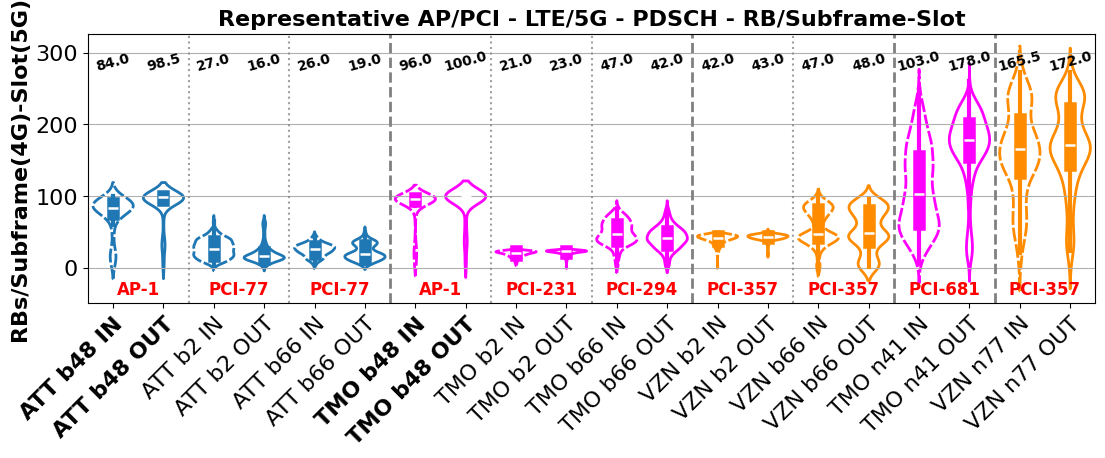

In [150]:
# LTE/5G - PDSCH - RB/Subframe-Slot
fig, ax = plt.subplots(figsize=(13, 3.5))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pdsch_att_nh_in[df_lte_pdsch_att_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 IN'),
    df_lte_pdsch_att_nh_out[df_lte_pdsch_att_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 OUT'),
    df_lte_pdsch_att_mno_in[(df_lte_pdsch_att_mno_in['Band Number'] == 2) & (df_lte_pdsch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b2 IN'),
    df_lte_pdsch_att_mno_out[(df_lte_pdsch_att_mno_out['Band Number'] == 2) & (df_lte_pdsch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pdsch_att_mno_in[(df_lte_pdsch_att_mno_in['Band Number'] == 66) & (df_lte_pdsch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b66 IN'),
    df_lte_pdsch_att_mno_out[(df_lte_pdsch_att_mno_out['Band Number'] == 66) & (df_lte_pdsch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b66 OUT'),
    df_lte_pdsch_tmo_nh_in[df_lte_pdsch_tmo_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 IN'),
    df_lte_pdsch_tmo_nh_out[df_lte_pdsch_tmo_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 OUT'),
    df_lte_pdsch_tmo_mno_in[(df_lte_pdsch_tmo_mno_in['Band Number']==2) & (df_lte_pdsch_tmo_mno_in['PCI'] == 231)].assign(Collection_plot='TMO b2 IN'),
    df_lte_pdsch_tmo_mno_out[(df_lte_pdsch_tmo_mno_out['Band Number']==2) & (df_lte_pdsch_tmo_mno_out['PCI'] == 231)].assign(Collection_plot='TMO b2 OUT'),
    df_lte_pdsch_tmo_mno_in[(df_lte_pdsch_tmo_mno_in['Band Number']==66) & (df_lte_pdsch_tmo_mno_in['PCI'] == 294)].assign(Collection_plot='TMO b66 IN'),
    df_lte_pdsch_tmo_mno_out[(df_lte_pdsch_tmo_mno_out['Band Number']==66) & (df_lte_pdsch_tmo_mno_out['PCI'] == 294)].assign(Collection_plot='TMO b66 OUT'),
    df_lte_pdsch_vzn_mno_in[(df_lte_pdsch_vzn_mno_in['Band Number'] == 2) & (df_lte_pdsch_vzn_mno_in['PCI'] == 357)].assign(Collection_plot='VZN b2 IN'),
    df_lte_pdsch_vzn_mno_out[(df_lte_pdsch_vzn_mno_out['Band Number'] == 2) & (df_lte_pdsch_vzn_mno_out['PCI'] == 357)].assign(Collection_plot='VZN b2 OUT'),
    df_lte_pdsch_vzn_mno_in[(df_lte_pdsch_vzn_mno_in['Band Number'] == 66) & (df_lte_pdsch_vzn_mno_in['PCI'] == 357)].assign(Collection_plot='VZN b66 IN'),
    df_lte_pdsch_vzn_mno_out[(df_lte_pdsch_vzn_mno_out['Band Number'] == 66) & (df_lte_pdsch_vzn_mno_out['PCI'] == 357)].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pdsch_tmo_mno_in[(df_5g_pdsch_tmo_mno_in['Band Number']==41) & (df_5g_pdsch_tmo_mno_in['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 IN'),
    df_5g_pdsch_tmo_mno_out[(df_5g_pdsch_tmo_mno_out['Band Number']==41) & (df_5g_pdsch_tmo_mno_out['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 OUT'),
    df_5g_pdsch_vzn_mno_in[(df_5g_pdsch_vzn_mno_in['Band Number']==77) & (df_5g_pdsch_vzn_mno_in['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 IN'),
    df_5g_pdsch_vzn_mno_out[(df_5g_pdsch_vzn_mno_out['Band Number']==77) & (df_5g_pdsch_vzn_mno_out['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='RB per Subframe-Slot', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 20, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=17.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')

plt.axvline(x=1.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=3.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=7.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=9.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=13.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
ax.text(0.05, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.15, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.25, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.35, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.45, 0.05, 'PCI-231', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.55, 0.05, 'PCI-294', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.65, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.75, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.85, 0.05, 'PCI-681', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.95, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
medians = data.groupby('Collection_plot')['RB per Subframe-Slot'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 275, f'{median_value:.1f}', horizontalalignment='center', color='black', fontsize=10, fontweight='bold', rotation=15)

dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RBs/Subframe(4G)-Slot(5G)', fontsize=16, fontweight='bold')
plt.title('Representative AP/PCI - LTE/5G - PDSCH - RB/Subframe-Slot', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

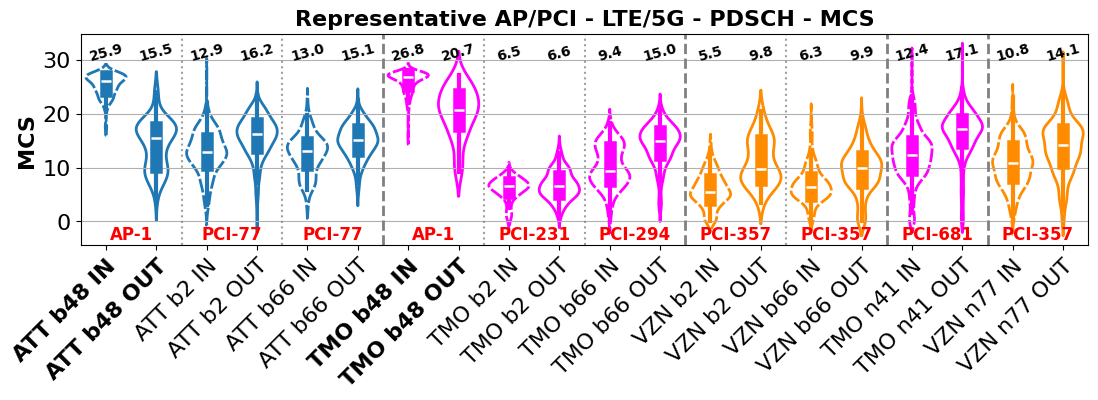

In [151]:
# LTE/5G - PDSCH - MCS
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pdsch_att_nh_in[df_lte_pdsch_att_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 IN'),
    df_lte_pdsch_att_nh_out[df_lte_pdsch_att_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 OUT'),
    df_lte_pdsch_att_mno_in[(df_lte_pdsch_att_mno_in['Band Number'] == 2) & (df_lte_pdsch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b2 IN'),
    df_lte_pdsch_att_mno_out[(df_lte_pdsch_att_mno_out['Band Number'] == 2) & (df_lte_pdsch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pdsch_att_mno_in[(df_lte_pdsch_att_mno_in['Band Number'] == 66) & (df_lte_pdsch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b66 IN'),
    df_lte_pdsch_att_mno_out[(df_lte_pdsch_att_mno_out['Band Number'] == 66) & (df_lte_pdsch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b66 OUT'),
    df_lte_pdsch_tmo_nh_in[df_lte_pdsch_tmo_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 IN'),
    df_lte_pdsch_tmo_nh_out[df_lte_pdsch_tmo_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 OUT'),
    df_lte_pdsch_tmo_mno_in[(df_lte_pdsch_tmo_mno_in['Band Number']==2) & (df_lte_pdsch_tmo_mno_in['PCI'] == 231)].assign(Collection_plot='TMO b2 IN'),
    df_lte_pdsch_tmo_mno_out[(df_lte_pdsch_tmo_mno_out['Band Number']==2) & (df_lte_pdsch_tmo_mno_out['PCI'] == 231)].assign(Collection_plot='TMO b2 OUT'),
    df_lte_pdsch_tmo_mno_in[(df_lte_pdsch_tmo_mno_in['Band Number']==66) & (df_lte_pdsch_tmo_mno_in['PCI'] == 294)].assign(Collection_plot='TMO b66 IN'),
    df_lte_pdsch_tmo_mno_out[(df_lte_pdsch_tmo_mno_out['Band Number']==66) & (df_lte_pdsch_tmo_mno_out['PCI'] == 294)].assign(Collection_plot='TMO b66 OUT'),
    df_lte_pdsch_vzn_mno_in[(df_lte_pdsch_vzn_mno_in['Band Number'] == 2) & (df_lte_pdsch_vzn_mno_in['PCI'] == 357)].assign(Collection_plot='VZN b2 IN'),
    df_lte_pdsch_vzn_mno_out[(df_lte_pdsch_vzn_mno_out['Band Number'] == 2) & (df_lte_pdsch_vzn_mno_out['PCI'] == 357)].assign(Collection_plot='VZN b2 OUT'),
    df_lte_pdsch_vzn_mno_in[(df_lte_pdsch_vzn_mno_in['Band Number'] == 66) & (df_lte_pdsch_vzn_mno_in['PCI'] == 357)].assign(Collection_plot='VZN b66 IN'),
    df_lte_pdsch_vzn_mno_out[(df_lte_pdsch_vzn_mno_out['Band Number'] == 66) & (df_lte_pdsch_vzn_mno_out['PCI'] == 357)].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pdsch_tmo_mno_in[(df_5g_pdsch_tmo_mno_in['Band Number']==41) & (df_5g_pdsch_tmo_mno_in['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 IN'),
    df_5g_pdsch_tmo_mno_out[(df_5g_pdsch_tmo_mno_out['Band Number']==41) & (df_5g_pdsch_tmo_mno_out['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 OUT'),
    df_5g_pdsch_vzn_mno_in[(df_5g_pdsch_vzn_mno_in['Band Number']==77) & (df_5g_pdsch_vzn_mno_in['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 IN'),
    df_5g_pdsch_vzn_mno_out[(df_5g_pdsch_vzn_mno_out['Band Number']==77) & (df_5g_pdsch_vzn_mno_out['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 OUT')
])
sns.violinplot(data=data.dropna(subset='MCS'), x='Collection_plot', y='MCS', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 20, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=17.5, color='gray', linestyle='--', linewidth=2)

plt.axvline(x=1.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=3.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=7.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=9.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=13.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
ax.text(0.05, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.15, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.25, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.35, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.45, 0.05, 'PCI-231', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.55, 0.05, 'PCI-294', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.65, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.75, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.85, 0.05, 'PCI-681', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.95, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
medians = data.groupby('Collection_plot')['MCS'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 30, f'{median_value:.1f}', horizontalalignment='center', color='black', fontsize=10, fontweight='bold', rotation=15)

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('MCS', fontsize=16, fontweight='bold')
plt.title('Representative AP/PCI - LTE/5G - PDSCH - MCS', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

#### PUSCH

##### Data cleaning

In [152]:
print(df_lte_pusch['Collection'].value_counts().sort_index())

Collection
Day1-ATT-MNO-DEF-IN       315
Day1-ATT-MNO-DEF-OUT      399
Day1-ATT-NH-IN            261
Day1-ATT-NH-OUT            68
Day1-TMO-MNO-DEF-IN       163
Day1-TMO-NH-IN            465
Day1-TMO-NH-OUT            64
Day2-ATT-MNO-4G-IN        335
Day2-ATT-MNO-4G-OUT       419
Day2-ATT-MNO-DEF-IN       299
Day2-ATT-MNO-DEF-OUT      364
Day2-ATT-MNO-DEF-OUTER    250
Day2-TMO-MNO-4G-IN        358
Day2-TMO-MNO-4G-OUT       335
Day2-VZN-MNO-4G-IN        256
Day2-VZN-MNO-4G-OUT       296
Day2-VZN-MNO-DEF-IN       319
Day2-VZN-MNO-DEF-OUT      336
Day2-VZN-MNO-DEF-OUTER    315
Day3_ATT-MNO-DEF-IN-L1    188
Day3_ATT-MNO-DEF-IN-L2    168
Day3_ATT-NH-IN-L1         133
Day3_ATT-NH-IN-L2         219
Day3_TMO-DEF-L1-V1         15
Day3_TMO-NH-L1            264
Day3_TMO-NH-L2            109
Day3_unnamed               44
Name: count, dtype: int64


In [153]:
df_lte_pusch_att_nh_in = df_lte_pusch[df_lte_pusch['Collection']=='Day1-ATT-NH-IN']
df_lte_pusch_att_nh_out = df_lte_pusch[df_lte_pusch['Collection']=='Day1-ATT-NH-OUT']

df_lte_pusch_att_mno_in = pd.concat([df_lte_pusch[df_lte_pusch['Collection']=='Day1-ATT-MNO-DEF-IN'],
                                    df_lte_pusch[df_lte_pusch['Collection']=='Day2-ATT-MNO-4G-IN'],
                                    df_lte_pusch[df_lte_pusch['Collection']=='Day2-ATT-MNO-DEF-IN']],
                                    ignore_index=True)
df_lte_pusch_att_mno_out = pd.concat([df_lte_pusch[df_lte_pusch['Collection']=='Day1-ATT-MNO-DEF-OUT'],
                                    df_lte_pusch[df_lte_pusch['Collection']=='Day2-ATT-MNO-4G-OUT'],
                                    df_lte_pusch[df_lte_pusch['Collection']=='Day2-ATT-MNO-DEF-OUT']],
                                    # df_lte_pusch[df_lte_pusch['Collection']=='Day2-ATT-MNO-DEF-OUTER']],
                                    ignore_index=True)

df_lte_pusch_tmo_nh_in = df_lte_pusch[df_lte_pusch['Collection']=='Day1-TMO-NH-IN']
df_lte_pusch_tmo_nh_out = df_lte_pusch[df_lte_pusch['Collection']=='Day1-TMO-NH-OUT']

df_lte_pusch_tmo_mno_in = pd.concat([df_lte_pusch[df_lte_pusch['Collection']=='Day1-TMO-MNO-DEF-IN'],
                                    df_lte_pusch[df_lte_pusch['Collection']=='Day2-TMO-MNO-4G-IN']],
                                    ignore_index=True)
df_lte_pusch_tmo_mno_out = df_lte_pusch[df_lte_pusch['Collection']=='Day2-TMO-MNO-4G-OUT']

df_lte_pusch_vzn_mno_in = pd.concat([df_lte_pusch[df_lte_pusch['Collection']=='Day2-VZN-MNO-4G-IN'],
                                    df_lte_pusch[df_lte_pusch['Collection']=='Day2-VZN-MNO-DEF-IN']],
                                    ignore_index=True)
df_lte_pusch_vzn_mno_out = pd.concat([df_lte_pusch[df_lte_pusch['Collection']=='Day2-VZN-MNO-4G-OUT'],
                                    df_lte_pusch[df_lte_pusch['Collection']=='Day2-VZN-MNO-DEF-OUT']],
                                    # df_lte_pusch[df_lte_pusch['Collection']=='Day2-VZN-MNO-DEF-OUTER']],
                                    ignore_index=True)

In [154]:
print(df_5g_pusch['Collection'].value_counts().sort_index())

Collection
Day1-TMO-MNO-DEF-IN       550
Day1-TMO-MNO-DEF-OUT      443
Day2-TMO-MNO-DEF-IN       297
Day2-TMO-MNO-DEF-OUT      357
Day2-TMO-MNO-DEF-OUTER    210
Day2-VZN-MNO-DEF-IN       239
Day2-VZN-MNO-DEF-OUT      334
Day2-VZN-MNO-DEF-OUTER    314
Day3_TMO-DEF-IN-L2        147
Day3_TMO-DEF-L1-V1        135
Day3_TMO-DEF-L2           105
Name: count, dtype: int64


In [155]:
df_5g_pusch_tmo_mno_in = pd.concat([df_5g_pusch[df_5g_pusch['Collection']=='Day1-TMO-MNO-DEF-IN'],
                                    df_5g_pusch[df_5g_pusch['Collection']=='Day2-TMO-MNO-DEF-IN']],
                                    ignore_index=True)
df_5g_pusch_tmo_mno_out = pd.concat([df_5g_pusch[df_5g_pusch['Collection']=='Day1-TMO-MNO-DEF-OUT'],
                                    df_5g_pusch[df_5g_pusch['Collection']=='Day2-TMO-MNO-DEF-OUT']],
                                    # df_5g_pusch[df_5g_pusch['Collection']=='Day2-TMO-MNO-DEF-OUTER']],
                                    ignore_index=True)

df_5g_pusch_vzn_mno_in = df_5g_pusch[df_5g_pusch['Collection']=='Day2-VZN-MNO-DEF-IN']
df_5g_pusch_vzn_mno_out = pd.concat([df_5g_pusch[df_5g_pusch['Collection']=='Day2-VZN-MNO-DEF-OUT']],
                                    # df_5g_pusch[df_5g_pusch['Collection']=='Day2-VZN-MNO-DEF-OUTER']],
                                    ignore_index=True)

##### print(): Statistics summary

In [156]:
print('LTE ATT NH IN')
print(df_lte_pusch_att_nh_in[['Band Number', 'UL Bandwidth']].value_counts().sort_index())
print('LTE ATT NH OUT')
print(df_lte_pusch_att_nh_out[['Band Number', 'UL Bandwidth']].value_counts().sort_index())
print('LTE ATT MNO IN')
print(df_lte_pusch_att_mno_in[['Band Number', 'UL Bandwidth']].value_counts().sort_index())
print('LTE ATT MNO OUT')
print(df_lte_pusch_att_mno_out[['Band Number', 'UL Bandwidth']].value_counts().sort_index())

LTE ATT NH IN
Band Number  UL Bandwidth
48           20              261
Name: count, dtype: int64
LTE ATT NH OUT
Band Number  UL Bandwidth
48           20              68
Name: count, dtype: int64
LTE ATT MNO IN
Band Number  UL Bandwidth
2            10               68
             15              419
12           10              128
14           10               63
30           10              271
Name: count, dtype: int64
LTE ATT MNO OUT
Band Number  UL Bandwidth
2            10              213
             15              818
30           10              151
Name: count, dtype: int64


In [157]:
print('LTE TMO NH IN')
print(df_lte_pusch_tmo_nh_in[['Band Number', 'UL Bandwidth']].value_counts().sort_index())
print('LTE TMO NH OUT')
print(df_lte_pusch_tmo_nh_out[['Band Number', 'UL Bandwidth']].value_counts().sort_index())
print('LTE TMO MNO IN')
print(df_lte_pusch_tmo_mno_in[['Band Number', 'UL Bandwidth']].value_counts().sort_index())
print('LTE TMO MNO OUT')
print(df_lte_pusch_tmo_mno_out[['Band Number', 'UL Bandwidth']].value_counts().sort_index())

LTE TMO NH IN
Band Number  UL Bandwidth
48           20              465
Name: count, dtype: int64
LTE TMO NH OUT
Band Number  UL Bandwidth
48           20              64
Name: count, dtype: int64
LTE TMO MNO IN
Band Number  UL Bandwidth
2            5                 9
66           20              512
Name: count, dtype: int64
LTE TMO MNO OUT
Band Number  UL Bandwidth
66           20              335
Name: count, dtype: int64


In [158]:
print('LTE VZN MNO IN')
print(df_lte_pusch_vzn_mno_in[['Band Number', 'UL Bandwidth']].value_counts().sort_index())
print('LTE VZN MNO OUT')
print(df_lte_pusch_vzn_mno_out[['Band Number', 'UL Bandwidth']].value_counts().sort_index())

LTE VZN MNO IN
Band Number  UL Bandwidth
5            10              235
13           10              298
66           10               42
Name: count, dtype: int64
LTE VZN MNO OUT
Band Number  UL Bandwidth
66           20              632
Name: count, dtype: int64


In [159]:
print('5G TMO MNO IN')
print(df_5g_pusch_tmo_mno_in[['Band Number', 'UL Bandwidth']].value_counts().sort_index())
print('5G TMO MNO OUT')
print(df_5g_pusch_tmo_mno_out[['Band Number', 'UL Bandwidth']].value_counts().sort_index())
print('5G VZN MNO IN')
print(df_5g_pusch_vzn_mno_in[['Band Number', 'UL Bandwidth']].value_counts().sort_index())
print('5G VZN MNO OUT')
print(df_5g_pusch_vzn_mno_out[['Band Number', 'UL Bandwidth']].value_counts().sort_index())

5G TMO MNO IN
Band Number  UL Bandwidth
25.0         14.0            525
41.0         88.0              2
             98.0            309
Name: count, dtype: int64
5G TMO MNO OUT
Band Number  UL Bandwidth
25.0         14.0            188
41.0         88.0             63
             98.0            549
Name: count, dtype: int64
5G VZN MNO IN
Band Number  UL Bandwidth
77.0         98.0            239
Name: count, dtype: int64
5G VZN MNO OUT
Band Number  UL Bandwidth
77.0         98.0            334
Name: count, dtype: int64


##### Plots: All Meas

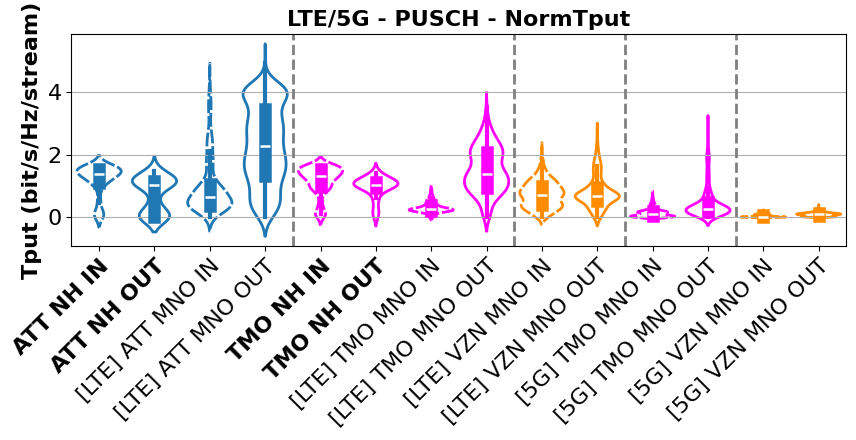

In [160]:
# LTE/5G - PUSCH - NormTput
fig, ax = plt.subplots(figsize=(10, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_att_nh_in.assign(Collection_plot='ATT NH IN'),
    df_lte_pusch_att_nh_out.assign(Collection_plot='ATT NH OUT'),
    df_lte_pusch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_pusch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_pusch_tmo_nh_out.assign(Collection_plot='TMO NH OUT'),
    df_lte_pusch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pusch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_pusch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_pusch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pusch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pusch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_pusch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_pusch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='Normalized Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 14, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=3.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=7.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT NH IN', 'ATT NH OUT', 'TMO NH IN', 'TMO NH OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (bit/s/Hz/stream)', fontsize=16, fontweight='bold')
plt.title('LTE/5G - PUSCH - NormTput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, labels

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_22484/481146942.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')


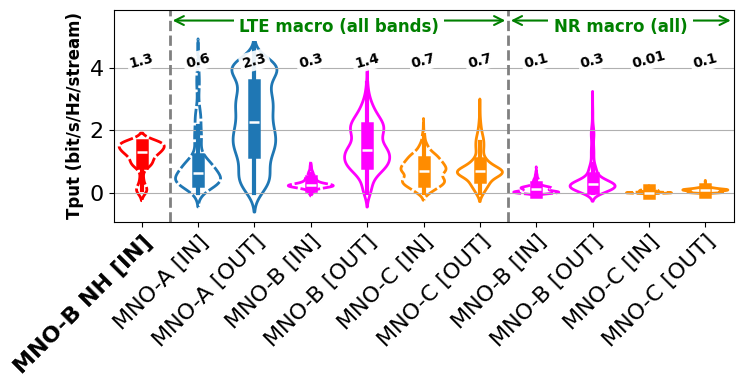

In [161]:
# LTE/5G - PUSCH - NormTput
fig, ax = plt.subplots(figsize=(8, 2.75))
palette = ['red', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_pusch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_pusch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pusch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pusch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_pusch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_pusch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pusch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pusch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_pusch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_pusch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='Normalized Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
new_labels = ['MNO-B NH [IN]', 'MNO-A [IN]', 'MNO-A [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]']
ax.set_xticklabels(new_labels, rotation=45, ha='right')

ax.collections[0].set_linestyle((0,(5,1)))
ax.collections[1].set_linestyle((0,(5,1)))
ax.collections[3].set_linestyle((0,(5,1)))
ax.collections[5].set_linestyle((0,(5,1)))
ax.collections[7].set_linestyle((0,(5,1)))
ax.collections[9].set_linestyle((0,(5,1)))

plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=6.5, color='gray', linestyle='--', linewidth=2)

medians = data.groupby('Collection_plot')['Normalized Throughput'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    if collection in ['[5G] VZN MNO IN']:
        ax.text(i, 4, f'{medians[collection]:.2f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))
    else:
        ax.text(i, 4, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))


ax.annotate(
    '', xy=(6.5, 0.95), xytext=(0.5, 0.95),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(4/11, 0.92, 'LTE macro (all bands)', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.annotate(
    '', xy=(10.5, 0.95), xytext=(6.5, 0.95),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(9/11, 0.92, 'NR macro (all)', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['MNO-B NH [IN]']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (bit/s/Hz/stream)', fontsize=12, fontweight='bold')
# plt.title('LTE/5G - Radio - RSRP/SS-RSRP', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.ylim(0, 6.2)
# plt.savefig('figs/pusch_all_normtput.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_22484/1471497107.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')


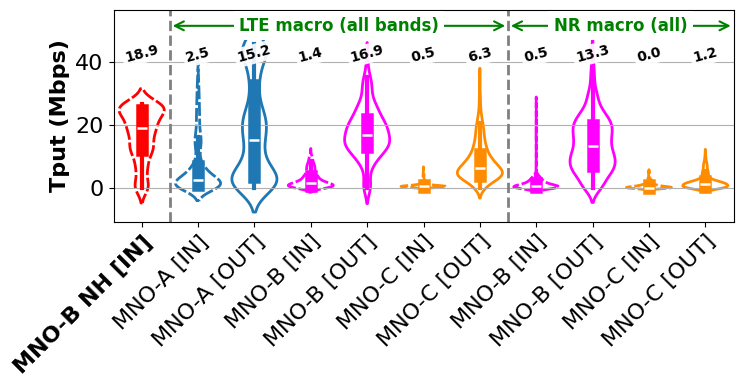

In [162]:
# LTE/5G - PUSCH - Tput
fig, ax = plt.subplots(figsize=(8, 2.75))
palette = ['red', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_pusch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_pusch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pusch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pusch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_pusch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_pusch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pusch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pusch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_pusch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_pusch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='Net PUSCH Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
new_labels = ['MNO-B NH [IN]', 'MNO-A [IN]', 'MNO-A [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]']
ax.set_xticklabels(new_labels, rotation=45, ha='right')

ax.collections[0].set_linestyle((0,(5,1)))
ax.collections[1].set_linestyle((0,(5,1)))
ax.collections[3].set_linestyle((0,(5,1)))
ax.collections[5].set_linestyle((0,(5,1)))
ax.collections[7].set_linestyle((0,(5,1)))
ax.collections[9].set_linestyle((0,(5,1)))

plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=6.5, color='gray', linestyle='--', linewidth=2)

medians = data.groupby('Collection_plot')['Net PUSCH Throughput'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 4e4, f'{medians[collection]/1e3:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

ax.annotate(
    '', xy=(6.5, 0.925), xytext=(0.5, 0.925),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(4/11, 0.925, 'LTE macro (all bands)', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.annotate(
    '', xy=(10.5, 0.925), xytext=(6.5, 0.925),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(9/11, 0.925, 'NR macro (all)', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['MNO-B NH [IN]']:
        label.set_fontweight('bold')

plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
# plt.title('LTE/5G - Radio - RSRP/SS-RSRP', fontsize=16, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
plt.grid(True, axis='y')
# plt.ylim(0, 6.2)
# plt.savefig('figs/pusch_all_tput.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_22484/1205582013.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')


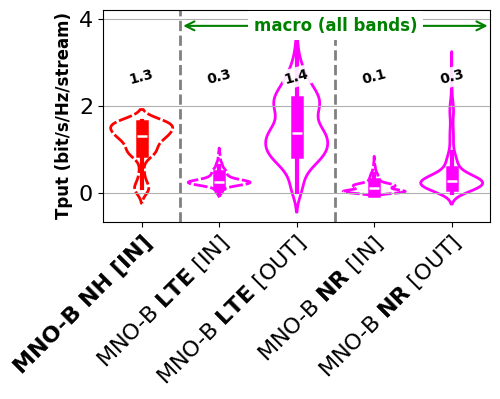

In [ ]:
# LTE/5G - PUSCH - NormTput
fig, ax = plt.subplots(figsize=(5, 2.75))
palette = ['red', 'magenta', 'magenta', 'magenta', 'magenta']
data = pd.concat([
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    # df_lte_pusch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    # df_lte_pusch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pusch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pusch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    # df_lte_pusch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    # df_lte_pusch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pusch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pusch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    # df_5g_pusch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    # df_5g_pusch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='Normalized Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
# new_labels = ['MNO-B NH [IN]', 'MNO-A [IN]', 'MNO-A [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]']
new_labels = ['MNO-B NH [IN]', r'MNO-B $\bf{LTE}$ [IN]', r'MNO-B $\bf{LTE}$ [OUT]', r'MNO-B $\bf{NR}$ [IN]', r'MNO-B $\bf{NR}$ [OUT]']
ax.set_xticklabels(new_labels, rotation=45, ha='right')

ax.collections[0].set_linestyle((0,(5,1)))
ax.collections[1].set_linestyle((0,(5,1)))
ax.collections[3].set_linestyle((0,(5,1)))
# ax.collections[5].set_linestyle((0,(5,1)))
# ax.collections[7].set_linestyle((0,(5,1)))
# ax.collections[9].set_linestyle((0,(5,1)))

plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=2)

medians = data.groupby('Collection_plot')['Normalized Throughput'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 2.5, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

ax.annotate(
    '', xy=(4.5, 0.925), xytext=(0.5, 0.925),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(3/5, 0.925, 'macro (all bands)', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

# ax.annotate(
#     '', xy=(10.5, 0.925), xytext=(6.5, 0.925),
#     xycoords=('data', 'axes fraction'),
#     textcoords=('data', 'axes fraction'),
#     arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
# )
# ax.text(9/11, 0.925, 'macro (all)', transform=ax.transAxes,
#         ha='center', va='center', fontsize=12, fontweight='bold', color='green',
#         bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()

for label in labels:
    if label.get_text() in ['MNO-B NH [IN]']:
        label.set_fontweight('bold')

plt.xlabel('')
plt.ylabel('Tput (bit/s/Hz/stream)', fontsize=12, fontweight='bold')
# plt.title('LTE/5G - Radio - RSRP/SS-RSRP', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.ylim(0, 6.2)
# plt.savefig('figs/pusch_select_normtput.pdf', bbox_inches='tight')
plt.show()
# del fig, ax, dx, dy, offset, label, data, palette, labels

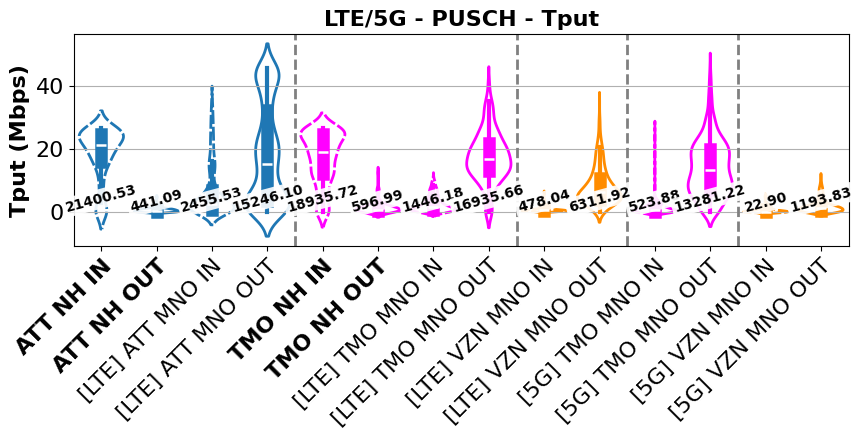

In [164]:
# LTE/5G - PUSCH - Tput
fig, ax = plt.subplots(figsize=(10, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_att_nh_in.assign(Collection_plot='ATT NH IN'),
    df_lte_pusch_att_nh_out.assign(Collection_plot='ATT NH OUT'),
    df_lte_pusch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_pusch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_pusch_tmo_nh_out.assign(Collection_plot='TMO NH OUT'),
    df_lte_pusch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pusch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_pusch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_pusch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pusch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pusch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_pusch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_pusch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='Net PUSCH Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)

medians = data.groupby('Collection_plot')['Net PUSCH Throughput'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 40, f'{medians[collection]:.2f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

for i in range(0, 14, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=3.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=7.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT NH IN', 'ATT NH OUT', 'TMO NH IN', 'TMO NH OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
plt.title('LTE/5G - PUSCH - Tput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, labels

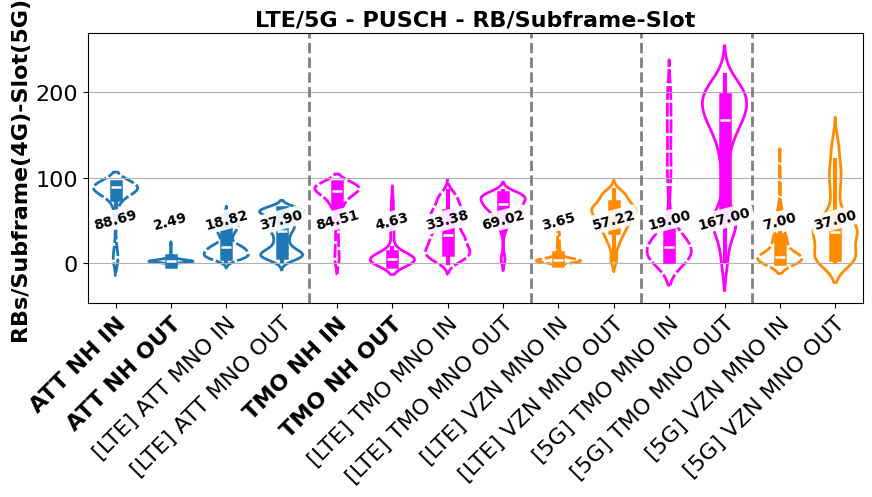

In [165]:
# LTE/5G - PUSCH - RB/Subframe-Slot
fig, ax = plt.subplots(figsize=(10, 3.5))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_att_nh_in.assign(Collection_plot='ATT NH IN'),
    df_lte_pusch_att_nh_out.assign(Collection_plot='ATT NH OUT'),
    df_lte_pusch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_pusch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_pusch_tmo_nh_out.assign(Collection_plot='TMO NH OUT'),
    df_lte_pusch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pusch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_pusch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_pusch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pusch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pusch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_pusch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_pusch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='RB per Subframe-Slot', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 14, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=3.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=7.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')

medians = data.groupby('Collection_plot')['RB per Subframe-Slot'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 40, f'{medians[collection]:.2f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT NH IN', 'ATT NH OUT', 'TMO NH IN', 'TMO NH OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RBs/Subframe(4G)-Slot(5G)', fontsize=16, fontweight='bold')
plt.title('LTE/5G - PUSCH - RB/Subframe-Slot', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, labels

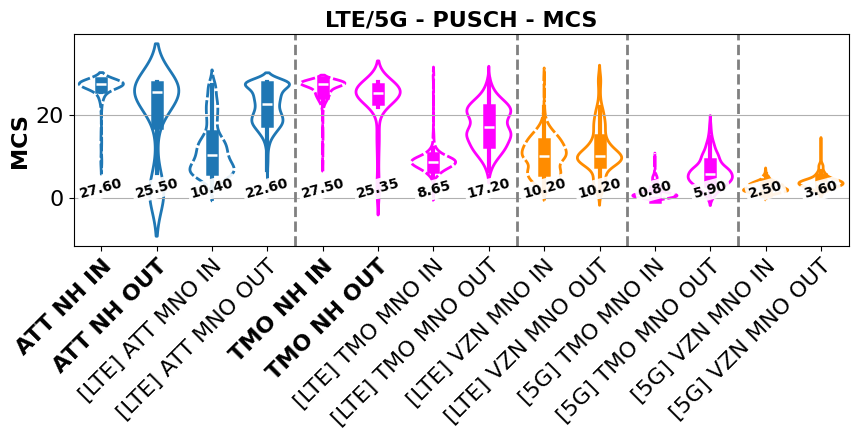

In [166]:
# LTE/5G - PUSCH - MCS
fig, ax = plt.subplots(figsize=(10, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_att_nh_in.assign(Collection_plot='ATT NH IN'),
    df_lte_pusch_att_nh_out.assign(Collection_plot='ATT NH OUT'),
    df_lte_pusch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_pusch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_pusch_tmo_nh_out.assign(Collection_plot='TMO NH OUT'),
    df_lte_pusch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pusch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_pusch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_pusch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pusch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pusch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_pusch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_pusch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data.dropna(subset=['MCS']), x='Collection_plot', y='MCS', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 14, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines

medians = data.groupby('Collection_plot')['MCS'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 0, f'{medians[collection]:.2f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

plt.axvline(x=3.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=7.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT NH IN', 'ATT NH OUT', 'TMO NH IN', 'TMO NH OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('MCS', fontsize=16, fontweight='bold')
plt.title('LTE/5G - PUSCH - MCS', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, labels

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_22484/3370165905.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')


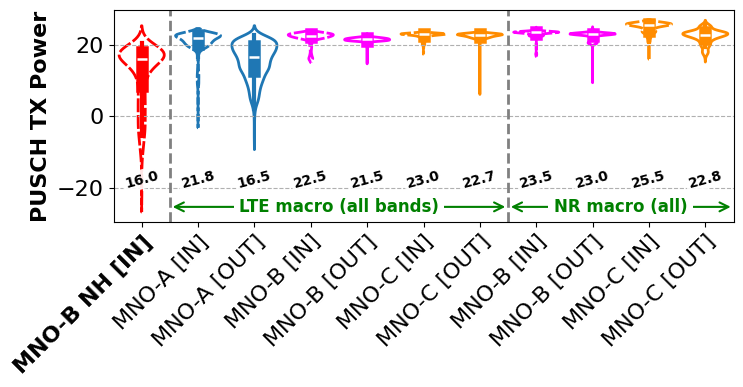

In [167]:
# LTE/5G - PUSCH - TX Power
fig, ax = plt.subplots(figsize=(8, 2.75))
palette = ['red', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_pusch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_pusch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pusch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pusch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_pusch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_pusch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pusch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pusch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_pusch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_pusch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data.dropna(subset=['PUSCH Tx Power']), x='Collection_plot', y='PUSCH Tx Power', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
new_labels = ['MNO-B NH [IN]', 'MNO-A [IN]', 'MNO-A [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]']
ax.set_xticklabels(new_labels, rotation=45, ha='right')

ax.collections[0].set_linestyle((0,(5,1)))
ax.collections[1].set_linestyle((0,(5,1)))
ax.collections[3].set_linestyle((0,(5,1)))
ax.collections[5].set_linestyle((0,(5,1)))
ax.collections[7].set_linestyle((0,(5,1)))
ax.collections[9].set_linestyle((0,(5,1)))

plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=6.5, color='gray', linestyle='--', linewidth=2)
medians = data.groupby('Collection_plot')['PUSCH Tx Power'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, -20, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

ax.annotate(
    '', xy=(6.5, 0.07), xytext=(0.5, 0.07),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(4/11, 0.07, 'LTE macro (all bands)', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.annotate(
    '', xy=(10.5, 0.07), xytext=(6.5, 0.07),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(9/11, 0.07, 'NR macro (all)', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['MNO-B NH [IN]']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('PUSCH TX Power', fontsize=16, fontweight='bold')
# plt.title('LTE/5G - PUSCH - TxPow', fontsize=16, fontweight='bold')
plt.grid(True, axis='y', linestyle='--')
# plt.savefig('figs/pusch_all_txpow.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_22484/3697835853.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')


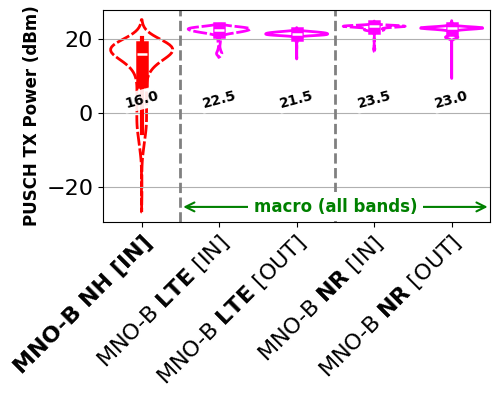

In [ ]:
# LTE/5G - PUSCH - TX Power
fig, ax = plt.subplots(figsize=(5, 2.75))
palette = ['red', 'magenta', 'magenta', 'magenta', 'magenta']
data = pd.concat([
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    # df_lte_pusch_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    # df_lte_pusch_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_pusch_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_pusch_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    # df_lte_pusch_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    # df_lte_pusch_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_pusch_tmo_mno_in.assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_pusch_tmo_mno_out.assign(Collection_plot='[5G] TMO MNO OUT'),
    # df_5g_pusch_vzn_mno_in.assign(Collection_plot='[5G] VZN MNO IN'),
    # df_5g_pusch_vzn_mno_out.assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data.dropna(subset=['PUSCH Tx Power']), x='Collection_plot', y='PUSCH Tx Power', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
# new_labels = ['MNO-B NH [IN]', 'MNO-A [IN]', 'MNO-A [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]']
new_labels = ['MNO-B NH [IN]', r'MNO-B $\bf{LTE}$ [IN]', r'MNO-B $\bf{LTE}$ [OUT]', r'MNO-B $\bf{NR}$ [IN]', r'MNO-B $\bf{NR}$ [OUT]']
ax.set_xticklabels(new_labels, rotation=45, ha='right')

ax.collections[0].set_linestyle((0,(5,1)))
ax.collections[1].set_linestyle((0,(5,1)))
ax.collections[3].set_linestyle((0,(5,1)))
# ax.collections[5].set_linestyle((0,(5,1)))
# ax.collections[7].set_linestyle((0,(5,1)))
# ax.collections[9].set_linestyle((0,(5,1)))

plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=2)

medians = data.groupby('Collection_plot')['PUSCH Tx Power'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 1.4, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

ax.annotate(
    '', xy=(4.5, 0.07), xytext=(0.5, 0.07),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(3/5, 0.07, 'macro (all bands)', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

# ax.annotate(
#     '', xy=(10.5, 0.925), xytext=(6.5, 0.925),
#     xycoords=('data', 'axes fraction'),
#     textcoords=('data', 'axes fraction'),
#     arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
# )
# ax.text(9/11, 0.925, 'macro (all)', transform=ax.transAxes,
#         ha='center', va='center', fontsize=12, fontweight='bold', color='green',
#         bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()

for label in labels:
    if label.get_text() in ['MNO-B NH [IN]']:
        label.set_fontweight('bold')

plt.xlabel('')
plt.ylabel('PUSCH TX Power (dBm)', fontsize=12, fontweight='bold')
# plt.title('LTE/5G - Radio - RSRP/SS-RSRP', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.ylim(0, 6.2)
# plt.savefig('figs/pusch_select_txpow.pdf', bbox_inches='tight')
plt.show()
# del fig, ax, dx, dy, offset, label, data, palette, labels

##### Plots: NH - In vs Out

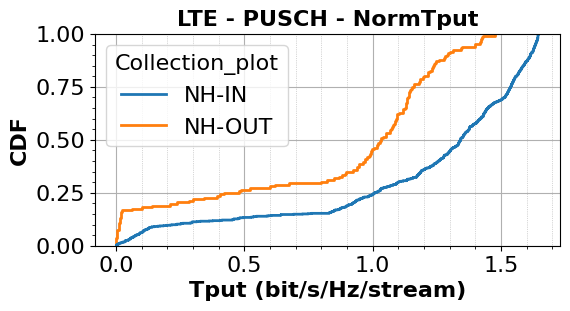

In [ ]:
# LTE - PUSCH - NormTput
fig, ax = plt.subplots(figsize=(6, 2.75))
data = pd.concat([
    df_lte_pusch_att_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_pusch_att_nh_out.assign(Collection_plot='NH-OUT'),
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_pusch_tmo_nh_out.assign(Collection_plot='NH-OUT'),
])
sns.ecdfplot(data=data, x='Normalized Throughput', hue='Collection_plot', ax=ax, linewidth=2)
plt.ylabel('CDF', fontsize=16, fontweight='bold')
plt.xlabel('Tput (bit/s/Hz/stream)', fontsize=16, fontweight='bold')
plt.title('LTE - PUSCH - NormTput', fontsize=16, fontweight='bold')
plt.grid(True)
ax.minorticks_on()
ax.xaxis.grid(True, which='minor', linestyle=':', linewidth=0.5)
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, data

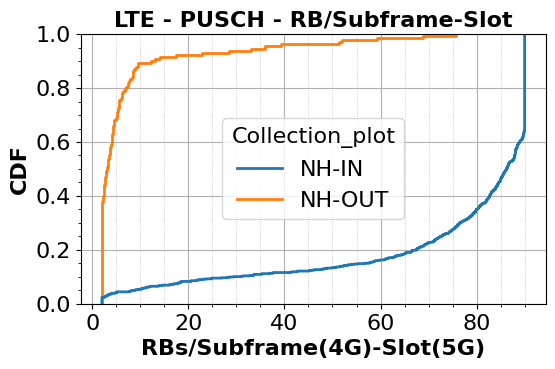

In [ ]:
# LTE - PUSCH - RB/Subframe-Slot
fig, ax = plt.subplots(figsize=(6, 3.5))
data = pd.concat([
    df_lte_pusch_att_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_pusch_att_nh_out.assign(Collection_plot='NH-OUT'),
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_pusch_tmo_nh_out.assign(Collection_plot='NH-OUT'),
])
sns.ecdfplot(data=data, x='RB per Subframe-Slot', hue='Collection_plot', ax=ax, linewidth=2)
plt.ylabel('CDF', fontsize=16, fontweight='bold')
plt.xlabel('RBs/Subframe(4G)-Slot(5G)', fontsize=16, fontweight='bold')
plt.title('LTE - PUSCH - RB/Subframe-Slot', fontsize=16, fontweight='bold')
plt.grid(True)
ax.minorticks_on()
ax.xaxis.grid(True, which='minor', linestyle=':', linewidth=0.5)
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, data

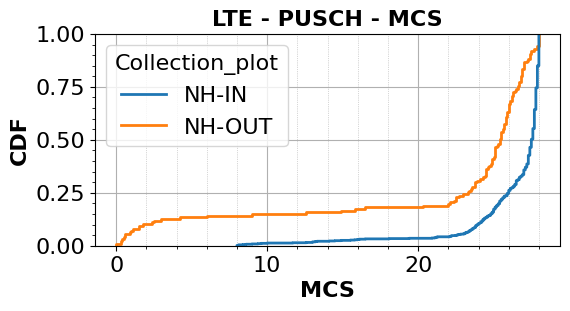

In [ ]:
# LTE - PUSCH - MCS
fig, ax = plt.subplots(figsize=(6, 2.75))
data = pd.concat([
    df_lte_pusch_att_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_pusch_att_nh_out.assign(Collection_plot='NH-OUT'),
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_pusch_tmo_nh_out.assign(Collection_plot='NH-OUT'),
])
sns.ecdfplot(data=data, x='MCS', hue='Collection_plot', ax=ax, linewidth=2)
plt.ylabel('CDF', fontsize=16, fontweight='bold')
plt.xlabel('MCS', fontsize=16, fontweight='bold')
plt.title('LTE - PUSCH - MCS', fontsize=16, fontweight='bold')
plt.grid(True)
ax.minorticks_on()
ax.xaxis.grid(True, which='minor', linestyle=':', linewidth=0.5)
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, data

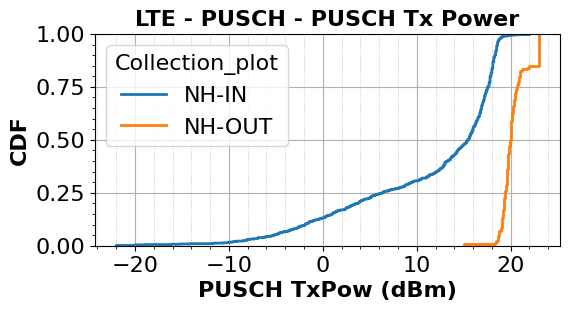

In [ ]:
# LTE - PUSCH - PUSCH Tx Power
fig, ax = plt.subplots(figsize=(6, 2.75))
data = pd.concat([
    df_lte_pusch_att_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_pusch_att_nh_out.assign(Collection_plot='NH-OUT'),
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_pusch_tmo_nh_out.assign(Collection_plot='NH-OUT'),
])
sns.ecdfplot(data=data, x='PUSCH Tx Power', hue='Collection_plot', ax=ax, linewidth=2)
plt.ylabel('CDF', fontsize=16, fontweight='bold')
plt.xlabel('PUSCH TxPow (dBm)', fontsize=16, fontweight='bold')
plt.title('LTE - PUSCH - PUSCH Tx Power', fontsize=16, fontweight='bold')
plt.grid(True)
ax.minorticks_on()
ax.xaxis.grid(True, which='minor', linestyle=':', linewidth=0.5)
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, data

##### Plots: Band specific

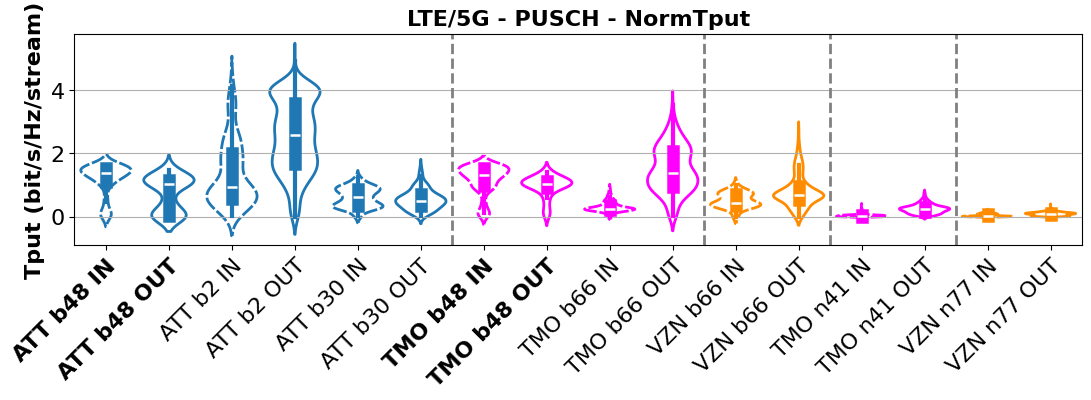

In [ ]:
# LTE/5G - PUSCH - NormTput
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_att_nh_in.assign(Collection_plot='ATT b48 IN'),
    df_lte_pusch_att_nh_out.assign(Collection_plot='ATT b48 OUT'),
    df_lte_pusch_att_mno_in[df_lte_pusch_att_mno_in['Band Number']==2].assign(Collection_plot='ATT b2 IN'),
    df_lte_pusch_att_mno_out[df_lte_pusch_att_mno_out['Band Number']==2].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pusch_att_mno_in[df_lte_pusch_att_mno_in['Band Number']==30].assign(Collection_plot='ATT b30 IN'),
    df_lte_pusch_att_mno_out[df_lte_pusch_att_mno_out['Band Number']==30].assign(Collection_plot='ATT b30 OUT'),
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='TMO b48 IN'),
    df_lte_pusch_tmo_nh_out.assign(Collection_plot='TMO b48 OUT'),
    # df_lte_pusch_tmo_mno_in[df_lte_pusch_tmo_mno_in['Band Number']==2].assign(Collection_plot='TMO b2 IN'),
    df_lte_pusch_tmo_mno_in[df_lte_pusch_tmo_mno_in['Band Number']==66].assign(Collection_plot='TMO b66 IN'),
    # df_lte_pusch_tmo_mno_out[df_lte_pusch_tmo_mno_out['Band Number']==2].assign(Collection_plot='TMO b2 OUT'),
    df_lte_pusch_tmo_mno_out[df_lte_pusch_tmo_mno_out['Band Number']==66].assign(Collection_plot='TMO b66 OUT'),
    # df_lte_pusch_vzn_mno_in[df_lte_pusch_vzn_mno_in['Band Number']==2].assign(Collection_plot='VZN b2 IN'),
    df_lte_pusch_vzn_mno_in[df_lte_pusch_vzn_mno_in['Band Number']==66].assign(Collection_plot='VZN b66 IN'),
    # df_lte_pusch_vzn_mno_out[df_lte_pusch_vzn_mno_out['Band Number']==2].assign(Collection_plot='VZN b2 OUT'),
    df_lte_pusch_vzn_mno_out[df_lte_pusch_vzn_mno_out['Band Number']==66].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pusch_tmo_mno_in[df_5g_pusch_tmo_mno_in['Band Number']==41].assign(Collection_plot='TMO n41 IN'),
    df_5g_pusch_tmo_mno_out[df_5g_pusch_tmo_mno_out['Band Number']==41].assign(Collection_plot='TMO n41 OUT'),
    df_5g_pusch_vzn_mno_in[df_5g_pusch_vzn_mno_in['Band Number']==77].assign(Collection_plot='VZN n77 IN'),
    df_5g_pusch_vzn_mno_out[df_5g_pusch_vzn_mno_out['Band Number']==77].assign(Collection_plot='VZN n77 OUT'),
])
sns.violinplot(data=data, x='Collection_plot', y='Normalized Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 16, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=13.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (bit/s/Hz/stream)', fontsize=16, fontweight='bold')
plt.title('LTE/5G - PUSCH - NormTput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

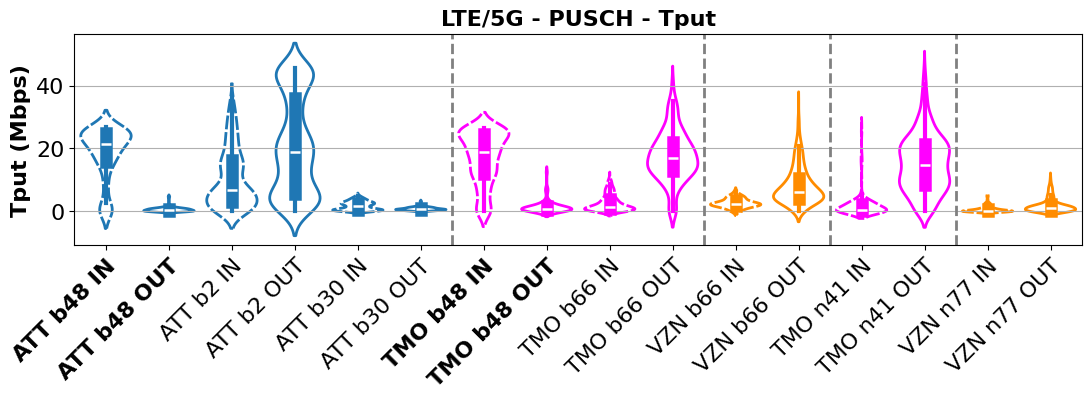

In [ ]:
# LTE/5G - PUSCH - Tput
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_att_nh_in.assign(Collection_plot='ATT b48 IN'),
    df_lte_pusch_att_nh_out.assign(Collection_plot='ATT b48 OUT'),
    df_lte_pusch_att_mno_in[df_lte_pusch_att_mno_in['Band Number']==2].assign(Collection_plot='ATT b2 IN'),
    df_lte_pusch_att_mno_out[df_lte_pusch_att_mno_out['Band Number']==2].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pusch_att_mno_in[df_lte_pusch_att_mno_in['Band Number']==30].assign(Collection_plot='ATT b30 IN'),
    df_lte_pusch_att_mno_out[df_lte_pusch_att_mno_out['Band Number']==30].assign(Collection_plot='ATT b30 OUT'),
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='TMO b48 IN'),
    df_lte_pusch_tmo_nh_out.assign(Collection_plot='TMO b48 OUT'),
    # df_lte_pusch_tmo_mno_in[df_lte_pusch_tmo_mno_in['Band Number']==2].assign(Collection_plot='TMO b2 IN'),
    df_lte_pusch_tmo_mno_in[df_lte_pusch_tmo_mno_in['Band Number']==66].assign(Collection_plot='TMO b66 IN'),
    # df_lte_pusch_tmo_mno_out[df_lte_pusch_tmo_mno_out['Band Number']==2].assign(Collection_plot='TMO b2 OUT'),
    df_lte_pusch_tmo_mno_out[df_lte_pusch_tmo_mno_out['Band Number']==66].assign(Collection_plot='TMO b66 OUT'),
    # df_lte_pusch_vzn_mno_in[df_lte_pusch_vzn_mno_in['Band Number']==2].assign(Collection_plot='VZN b2 IN'),
    df_lte_pusch_vzn_mno_in[df_lte_pusch_vzn_mno_in['Band Number']==66].assign(Collection_plot='VZN b66 IN'),
    # df_lte_pusch_vzn_mno_out[df_lte_pusch_vzn_mno_out['Band Number']==2].assign(Collection_plot='VZN b2 OUT'),
    df_lte_pusch_vzn_mno_out[df_lte_pusch_vzn_mno_out['Band Number']==66].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pusch_tmo_mno_in[df_5g_pusch_tmo_mno_in['Band Number']==41].assign(Collection_plot='TMO n41 IN'),
    df_5g_pusch_tmo_mno_out[df_5g_pusch_tmo_mno_out['Band Number']==41].assign(Collection_plot='TMO n41 OUT'),
    df_5g_pusch_vzn_mno_in[df_5g_pusch_vzn_mno_in['Band Number']==77].assign(Collection_plot='VZN n77 IN'),
    df_5g_pusch_vzn_mno_out[df_5g_pusch_vzn_mno_out['Band Number']==77].assign(Collection_plot='VZN n77 OUT'),
])
sns.violinplot(data=data, x='Collection_plot', y='Net PUSCH Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 16, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=13.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
plt.title('LTE/5G - PUSCH - Tput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

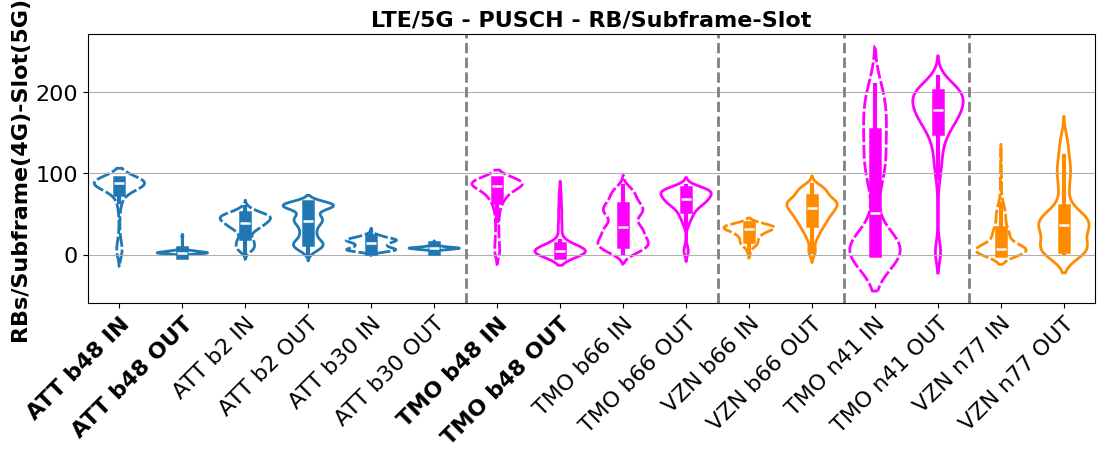

In [ ]:
# LTE/5G - PUSCH - RB/Subframe-Slot
fig, ax = plt.subplots(figsize=(13, 3.5))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_att_nh_in.assign(Collection_plot='ATT b48 IN'),
    df_lte_pusch_att_nh_out.assign(Collection_plot='ATT b48 OUT'),
    df_lte_pusch_att_mno_in[df_lte_pusch_att_mno_in['Band Number']==2].assign(Collection_plot='ATT b2 IN'),
    df_lte_pusch_att_mno_out[df_lte_pusch_att_mno_out['Band Number']==2].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pusch_att_mno_in[df_lte_pusch_att_mno_in['Band Number']==30].assign(Collection_plot='ATT b30 IN'),
    df_lte_pusch_att_mno_out[df_lte_pusch_att_mno_out['Band Number']==30].assign(Collection_plot='ATT b30 OUT'),
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='TMO b48 IN'),
    df_lte_pusch_tmo_nh_out.assign(Collection_plot='TMO b48 OUT'),
    # df_lte_pusch_tmo_mno_in[df_lte_pusch_tmo_mno_in['Band Number']==2].assign(Collection_plot='TMO b2 IN'),
    df_lte_pusch_tmo_mno_in[df_lte_pusch_tmo_mno_in['Band Number']==66].assign(Collection_plot='TMO b66 IN'),
    # df_lte_pusch_tmo_mno_out[df_lte_pusch_tmo_mno_out['Band Number']==2].assign(Collection_plot='TMO b2 OUT'),
    df_lte_pusch_tmo_mno_out[df_lte_pusch_tmo_mno_out['Band Number']==66].assign(Collection_plot='TMO b66 OUT'),
    # df_lte_pusch_vzn_mno_in[df_lte_pusch_vzn_mno_in['Band Number']==2].assign(Collection_plot='VZN b2 IN'),
    df_lte_pusch_vzn_mno_in[df_lte_pusch_vzn_mno_in['Band Number']==66].assign(Collection_plot='VZN b66 IN'),
    # df_lte_pusch_vzn_mno_out[df_lte_pusch_vzn_mno_out['Band Number']==2].assign(Collection_plot='VZN b2 OUT'),
    df_lte_pusch_vzn_mno_out[df_lte_pusch_vzn_mno_out['Band Number']==66].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pusch_tmo_mno_in[df_5g_pusch_tmo_mno_in['Band Number']==41].assign(Collection_plot='TMO n41 IN'),
    df_5g_pusch_tmo_mno_out[df_5g_pusch_tmo_mno_out['Band Number']==41].assign(Collection_plot='TMO n41 OUT'),
    df_5g_pusch_vzn_mno_in[df_5g_pusch_vzn_mno_in['Band Number']==77].assign(Collection_plot='VZN n77 IN'),
    df_5g_pusch_vzn_mno_out[df_5g_pusch_vzn_mno_out['Band Number']==77].assign(Collection_plot='VZN n77 OUT'),
])
sns.violinplot(data=data, x='Collection_plot', y='RB per Subframe-Slot', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 16, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=13.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RBs/Subframe(4G)-Slot(5G)', fontsize=16, fontweight='bold')
plt.title('LTE/5G - PUSCH - RB/Subframe-Slot', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

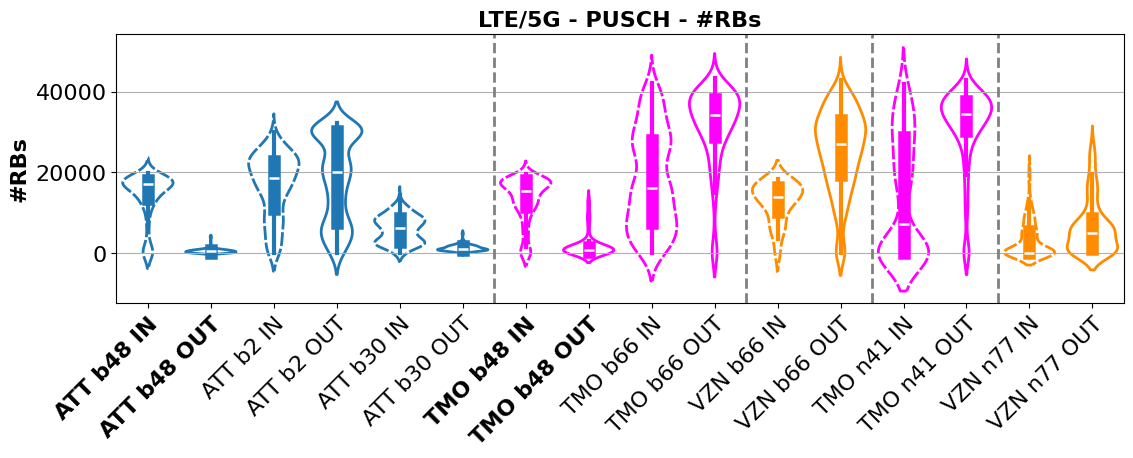

In [60]:
# LTE/5G - PUSCH - #RBs
fig, ax = plt.subplots(figsize=(13, 3.5))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_att_nh_in.assign(Collection_plot='ATT b48 IN'),
    df_lte_pusch_att_nh_out.assign(Collection_plot='ATT b48 OUT'),
    df_lte_pusch_att_mno_in[df_lte_pusch_att_mno_in['Band Number']==2].assign(Collection_plot='ATT b2 IN'),
    df_lte_pusch_att_mno_out[df_lte_pusch_att_mno_out['Band Number']==2].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pusch_att_mno_in[df_lte_pusch_att_mno_in['Band Number']==30].assign(Collection_plot='ATT b30 IN'),
    df_lte_pusch_att_mno_out[df_lte_pusch_att_mno_out['Band Number']==30].assign(Collection_plot='ATT b30 OUT'),
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='TMO b48 IN'),
    df_lte_pusch_tmo_nh_out.assign(Collection_plot='TMO b48 OUT'),
    # df_lte_pusch_tmo_mno_in[df_lte_pusch_tmo_mno_in['Band Number']==2].assign(Collection_plot='TMO b2 IN'),
    df_lte_pusch_tmo_mno_in[df_lte_pusch_tmo_mno_in['Band Number']==66].assign(Collection_plot='TMO b66 IN'),
    # df_lte_pusch_tmo_mno_out[df_lte_pusch_tmo_mno_out['Band Number']==2].assign(Collection_plot='TMO b2 OUT'),
    df_lte_pusch_tmo_mno_out[df_lte_pusch_tmo_mno_out['Band Number']==66].assign(Collection_plot='TMO b66 OUT'),
    # df_lte_pusch_vzn_mno_in[df_lte_pusch_vzn_mno_in['Band Number']==2].assign(Collection_plot='VZN b2 IN'),
    df_lte_pusch_vzn_mno_in[df_lte_pusch_vzn_mno_in['Band Number']==66].assign(Collection_plot='VZN b66 IN'),
    # df_lte_pusch_vzn_mno_out[df_lte_pusch_vzn_mno_out['Band Number']==2].assign(Collection_plot='VZN b2 OUT'),
    df_lte_pusch_vzn_mno_out[df_lte_pusch_vzn_mno_out['Band Number']==66].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pusch_tmo_mno_in[df_5g_pusch_tmo_mno_in['Band Number']==41].assign(Collection_plot='TMO n41 IN'),
    df_5g_pusch_tmo_mno_out[df_5g_pusch_tmo_mno_out['Band Number']==41].assign(Collection_plot='TMO n41 OUT'),
    df_5g_pusch_vzn_mno_in[df_5g_pusch_vzn_mno_in['Band Number']==77].assign(Collection_plot='VZN n77 IN'),
    df_5g_pusch_vzn_mno_out[df_5g_pusch_vzn_mno_out['Band Number']==77].assign(Collection_plot='VZN n77 OUT'),
])
sns.violinplot(data=data, x='Collection_plot', y='RBs', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 16, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=13.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('#RBs', fontsize=16, fontweight='bold')
plt.title('LTE/5G - PUSCH - #RBs', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

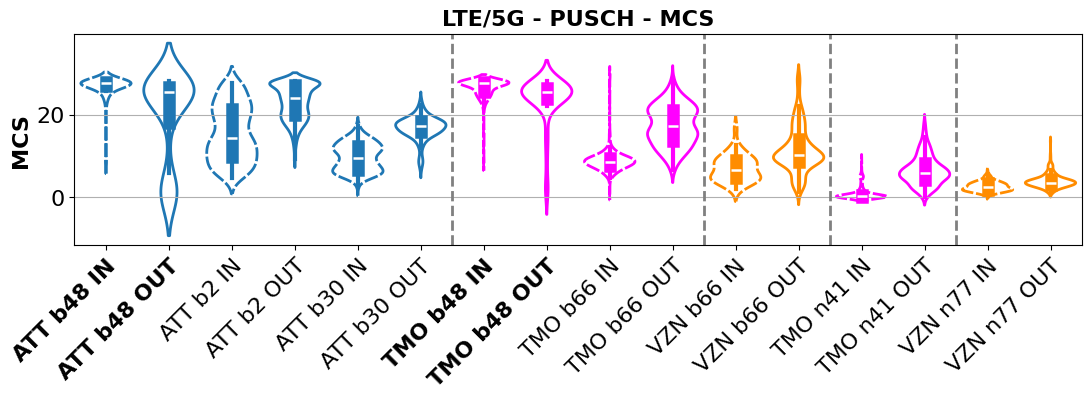

In [ ]:
# LTE/5G - PUSCH - MCS
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_att_nh_in.assign(Collection_plot='ATT b48 IN'),
    df_lte_pusch_att_nh_out.assign(Collection_plot='ATT b48 OUT'),
    df_lte_pusch_att_mno_in[df_lte_pusch_att_mno_in['Band Number']==2].assign(Collection_plot='ATT b2 IN'),
    df_lte_pusch_att_mno_out[df_lte_pusch_att_mno_out['Band Number']==2].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pusch_att_mno_in[df_lte_pusch_att_mno_in['Band Number']==30].assign(Collection_plot='ATT b30 IN'),
    df_lte_pusch_att_mno_out[df_lte_pusch_att_mno_out['Band Number']==30].assign(Collection_plot='ATT b30 OUT'),
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='TMO b48 IN'),
    df_lte_pusch_tmo_nh_out.assign(Collection_plot='TMO b48 OUT'),
    # df_lte_pusch_tmo_mno_in[df_lte_pusch_tmo_mno_in['Band Number']==2].assign(Collection_plot='TMO b2 IN'),
    df_lte_pusch_tmo_mno_in[df_lte_pusch_tmo_mno_in['Band Number']==66].assign(Collection_plot='TMO b66 IN'),
    # df_lte_pusch_tmo_mno_out[df_lte_pusch_tmo_mno_out['Band Number']==2].assign(Collection_plot='TMO b2 OUT'),
    df_lte_pusch_tmo_mno_out[df_lte_pusch_tmo_mno_out['Band Number']==66].assign(Collection_plot='TMO b66 OUT'),
    # df_lte_pusch_vzn_mno_in[df_lte_pusch_vzn_mno_in['Band Number']==2].assign(Collection_plot='VZN b2 IN'),
    df_lte_pusch_vzn_mno_in[df_lte_pusch_vzn_mno_in['Band Number']==66].assign(Collection_plot='VZN b66 IN'),
    # df_lte_pusch_vzn_mno_out[df_lte_pusch_vzn_mno_out['Band Number']==2].assign(Collection_plot='VZN b2 OUT'),
    df_lte_pusch_vzn_mno_out[df_lte_pusch_vzn_mno_out['Band Number']==66].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pusch_tmo_mno_in[df_5g_pusch_tmo_mno_in['Band Number']==41].assign(Collection_plot='TMO n41 IN'),
    df_5g_pusch_tmo_mno_out[df_5g_pusch_tmo_mno_out['Band Number']==41].assign(Collection_plot='TMO n41 OUT'),
    df_5g_pusch_vzn_mno_in[df_5g_pusch_vzn_mno_in['Band Number']==77].assign(Collection_plot='VZN n77 IN'),
    df_5g_pusch_vzn_mno_out[df_5g_pusch_vzn_mno_out['Band Number']==77].assign(Collection_plot='VZN n77 OUT'),
])
sns.violinplot(data=data.dropna(subset='MCS'), x='Collection_plot', y='MCS', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 16, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=13.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('MCS', fontsize=16, fontweight='bold')
plt.title('LTE/5G - PUSCH - MCS', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

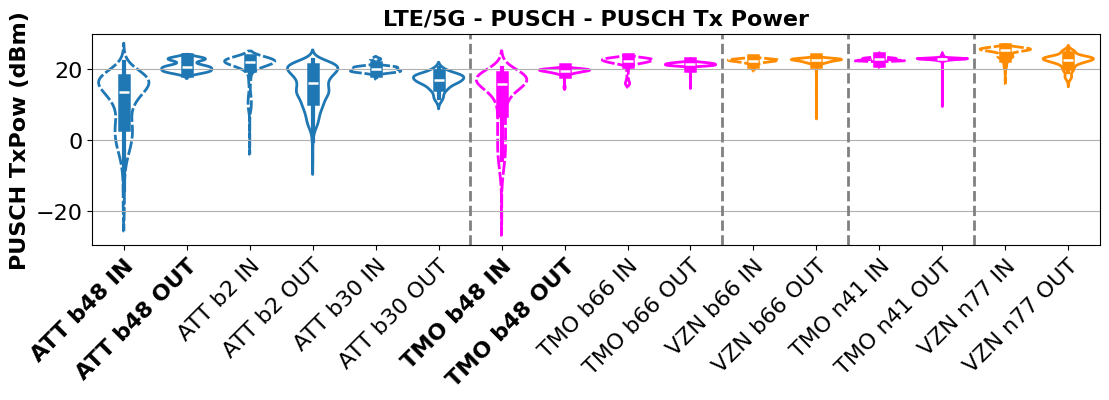

In [48]:
# LTE/5G - PUSCH - PUSCH Tx Power
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_att_nh_in.assign(Collection_plot='ATT b48 IN'),
    df_lte_pusch_att_nh_out.assign(Collection_plot='ATT b48 OUT'),
    df_lte_pusch_att_mno_in[df_lte_pusch_att_mno_in['Band Number']==2].assign(Collection_plot='ATT b2 IN'),
    df_lte_pusch_att_mno_out[df_lte_pusch_att_mno_out['Band Number']==2].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pusch_att_mno_in[df_lte_pusch_att_mno_in['Band Number']==30].assign(Collection_plot='ATT b30 IN'),
    df_lte_pusch_att_mno_out[df_lte_pusch_att_mno_out['Band Number']==30].assign(Collection_plot='ATT b30 OUT'),
    df_lte_pusch_tmo_nh_in.assign(Collection_plot='TMO b48 IN'),
    df_lte_pusch_tmo_nh_out.assign(Collection_plot='TMO b48 OUT'),
    # df_lte_pusch_tmo_mno_in[df_lte_pusch_tmo_mno_in['Band Number']==2].assign(Collection_plot='TMO b2 IN'),
    df_lte_pusch_tmo_mno_in[df_lte_pusch_tmo_mno_in['Band Number']==66].assign(Collection_plot='TMO b66 IN'),
    # df_lte_pusch_tmo_mno_out[df_lte_pusch_tmo_mno_out['Band Number']==2].assign(Collection_plot='TMO b2 OUT'),
    df_lte_pusch_tmo_mno_out[df_lte_pusch_tmo_mno_out['Band Number']==66].assign(Collection_plot='TMO b66 OUT'),
    # df_lte_pusch_vzn_mno_in[df_lte_pusch_vzn_mno_in['Band Number']==2].assign(Collection_plot='VZN b2 IN'),
    df_lte_pusch_vzn_mno_in[df_lte_pusch_vzn_mno_in['Band Number']==66].assign(Collection_plot='VZN b66 IN'),
    # df_lte_pusch_vzn_mno_out[df_lte_pusch_vzn_mno_out['Band Number']==2].assign(Collection_plot='VZN b2 OUT'),
    df_lte_pusch_vzn_mno_out[df_lte_pusch_vzn_mno_out['Band Number']==66].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pusch_tmo_mno_in[df_5g_pusch_tmo_mno_in['Band Number']==41].assign(Collection_plot='TMO n41 IN'),
    df_5g_pusch_tmo_mno_out[df_5g_pusch_tmo_mno_out['Band Number']==41].assign(Collection_plot='TMO n41 OUT'),
    df_5g_pusch_vzn_mno_in[df_5g_pusch_vzn_mno_in['Band Number']==77].assign(Collection_plot='VZN n77 IN'),
    df_5g_pusch_vzn_mno_out[df_5g_pusch_vzn_mno_out['Band Number']==77].assign(Collection_plot='VZN n77 OUT'),
])
sns.violinplot(data=data.dropna(subset='PUSCH Tx Power'), x='Collection_plot', y='PUSCH Tx Power', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 16, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=13.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('PUSCH TxPow (dBm)', fontsize=16, fontweight='bold')
plt.title('LTE/5G - PUSCH - PUSCH Tx Power', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

##### print(): PCI statistics

Summary of Representative PCIs:

NH IN - AP 1 - PCI 4,7

NH OUT - AP 6 - PCI 8,15

ATT b2,30 - PCI 77

TMO b66 - PCI 294

VZN b66 - PCI 357

TMO n41 - PCI 681

VZN n77 - PCI 357

In [ ]:
print('LTE ATT NH IN')
print(df_lte_pusch_att_nh_in[['Band Number', 'PCI']].value_counts().sort_index())
print('LTE ATT NH OUT')
print(df_lte_pusch_att_nh_out[['Band Number', 'PCI']].value_counts().sort_index())
print('LTE ATT MNO IN')
print(df_lte_pusch_att_mno_in[['Band Number', 'PCI']].value_counts().sort_index())
print('LTE ATT MNO OUT')
print(df_lte_pusch_att_mno_out[['Band Number', 'PCI']].value_counts().sort_index())

LTE ATT NH IN
Band Number  PCI
48           4      66
             8      22
             9       3
             13     69
             20     11
             23     63
             25     27
Name: count, dtype: int64
LTE ATT NH OUT
Band Number  PCI
48           7      46
             8      22
Name: count, dtype: int64
LTE ATT MNO IN
Band Number  PCI
2            77      61
             80       4
             422     27
             430    395
12           77      64
             80      17
             81      43
             149      4
14           81      63
30           77     271
Name: count, dtype: int64
LTE ATT MNO OUT
Band Number  PCI
2            77     308
             430    723
30           77     151
Name: count, dtype: int64


In [ ]:
print('LTE TMO NH IN')
print(df_lte_pusch_tmo_nh_in[['Band Number', 'PCI']].value_counts().sort_index())
print('LTE TMO NH OUT')
print(df_lte_pusch_tmo_nh_out[['Band Number', 'PCI']].value_counts().sort_index())
print('LTE TMO MNO IN')
print(df_lte_pusch_tmo_mno_in[['Band Number', 'PCI']].value_counts().sort_index())
print('LTE TMO MNO OUT')
print(df_lte_pusch_tmo_mno_out[['Band Number', 'PCI']].value_counts().sort_index())

LTE TMO NH IN
Band Number  PCI
48           4      160
             8       44
             9       22
             13     124
             23      88
             25      27
Name: count, dtype: int64
LTE TMO NH OUT
Band Number  PCI
48           4      43
             8      21
Name: count, dtype: int64
LTE TMO MNO IN
Band Number  PCI
2            462      9
66           294    232
             330    280
Name: count, dtype: int64
LTE TMO MNO OUT
Band Number  PCI
66           294    173
             330    162
Name: count, dtype: int64


In [ ]:
print('LTE VZN MNO IN')
print(df_lte_pusch_vzn_mno_in[['Band Number', 'PCI']].value_counts().sort_index())
print('LTE VZN MNO OUT')
print(df_lte_pusch_vzn_mno_out[['Band Number', 'PCI']].value_counts().sort_index())

LTE VZN MNO IN
Band Number  PCI
5            357    235
13           125     92
             155     37
             318     22
             357    147
66           357     42
Name: count, dtype: int64
LTE VZN MNO OUT
Band Number  PCI
66           125    375
             357    257
Name: count, dtype: int64


In [ ]:
print('5G TMO MNO IN')
print(df_5g_pusch_tmo_mno_in[['Band Number', 'PCI']].value_counts().sort_index())
print('5G TMO MNO OUT')
print(df_5g_pusch_tmo_mno_out[['Band Number', 'PCI']].value_counts().sort_index())
print('5G VZN MNO IN')
print(df_5g_pusch_vzn_mno_in[['Band Number', 'PCI']].value_counts().sort_index())
print('5G VZN MNO OUT')
print(df_5g_pusch_vzn_mno_out[['Band Number', 'PCI']].value_counts().sort_index())

5G TMO MNO IN
Band Number  PCI  
25.0         447.0     95
             585.0    430
41.0         681.0    321
Name: count, dtype: int64
5G TMO MNO OUT
Band Number  PCI  
25.0         447.0    167
             585.0     21
41.0         681.0    612
Name: count, dtype: int64
5G VZN MNO IN
Band Number  PCI  
77.0         357.0    239
Name: count, dtype: int64
5G VZN MNO OUT
Band Number  PCI  
77.0         357.0    334
Name: count, dtype: int64


##### Plots: PCI specific

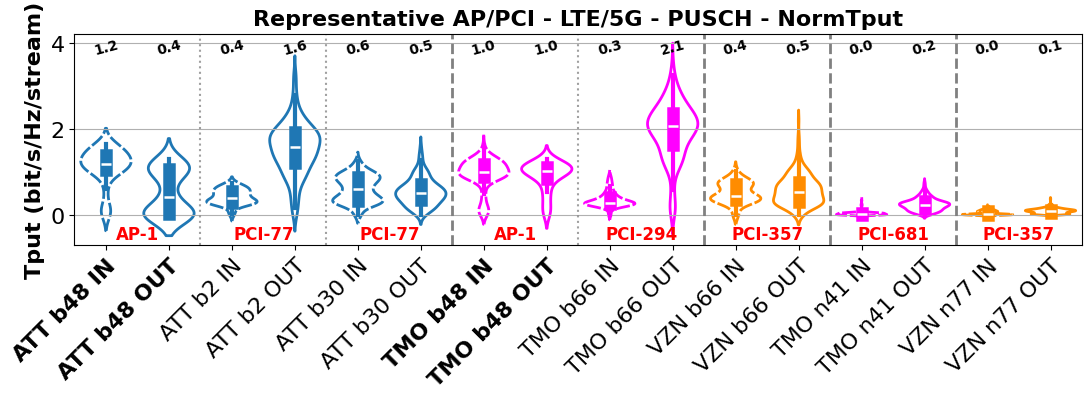

In [ ]:
# LTE/5G - PUSCH - NormTput
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_att_nh_in[df_lte_pusch_att_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 IN'),
    df_lte_pusch_att_nh_out[df_lte_pusch_att_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 OUT'),
    df_lte_pusch_att_mno_in[(df_lte_pusch_att_mno_in['Band Number'] == 2) & (df_lte_pusch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b2 IN'),
    df_lte_pusch_att_mno_out[(df_lte_pusch_att_mno_out['Band Number'] == 2) & (df_lte_pusch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pusch_att_mno_in[(df_lte_pusch_att_mno_in['Band Number'] == 30) & (df_lte_pusch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b30 IN'),
    df_lte_pusch_att_mno_out[(df_lte_pusch_att_mno_out['Band Number'] == 30) & (df_lte_pusch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b30 OUT'),
    df_lte_pusch_tmo_nh_in[df_lte_pusch_tmo_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 IN'),
    df_lte_pusch_tmo_nh_out[df_lte_pusch_tmo_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 OUT'),
    df_lte_pusch_tmo_mno_in[(df_lte_pusch_tmo_mno_in['Band Number']==66) & (df_lte_pusch_tmo_mno_in['PCI'] == 294)].assign(Collection_plot='TMO b66 IN'),
    df_lte_pusch_tmo_mno_out[(df_lte_pusch_tmo_mno_out['Band Number']==66) & (df_lte_pusch_tmo_mno_out['PCI'] == 294)].assign(Collection_plot='TMO b66 OUT'),
    df_lte_pusch_vzn_mno_in[(df_lte_pusch_vzn_mno_in['Band Number'] == 66) & (df_lte_pusch_vzn_mno_in['PCI'] == 357)].assign(Collection_plot='VZN b66 IN'),
    df_lte_pusch_vzn_mno_out[(df_lte_pusch_vzn_mno_out['Band Number'] == 66) & (df_lte_pusch_vzn_mno_out['PCI'] == 357)].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pusch_tmo_mno_in[(df_5g_pusch_tmo_mno_in['Band Number']==41) & (df_5g_pusch_tmo_mno_in['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 IN'),
    df_5g_pusch_tmo_mno_out[(df_5g_pusch_tmo_mno_out['Band Number']==41) & (df_5g_pusch_tmo_mno_out['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 OUT'),
    df_5g_pusch_vzn_mno_in[(df_5g_pusch_vzn_mno_in['Band Number']==77) & (df_5g_pusch_vzn_mno_in['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 IN'),
    df_5g_pusch_vzn_mno_out[(df_5g_pusch_vzn_mno_out['Band Number']==77) & (df_5g_pusch_vzn_mno_out['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='Normalized Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 16, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=13.5, color='gray', linestyle='--', linewidth=2)

plt.axvline(x=1.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=3.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=7.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
ax.text(1/16, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(3/16, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(5/16, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(7/16, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(9/16, 0.05, 'PCI-294', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(11/16, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(13/16, 0.05, 'PCI-681', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(15/16, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
medians = data.groupby('Collection_plot')['Normalized Throughput'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 3.75, f'{median_value:.1f}', horizontalalignment='center', color='black', fontsize=10, fontweight='bold', rotation=15)

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (bit/s/Hz/stream)', fontsize=16, fontweight='bold')
plt.title('Representative AP/PCI - LTE/5G - PUSCH - NormTput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

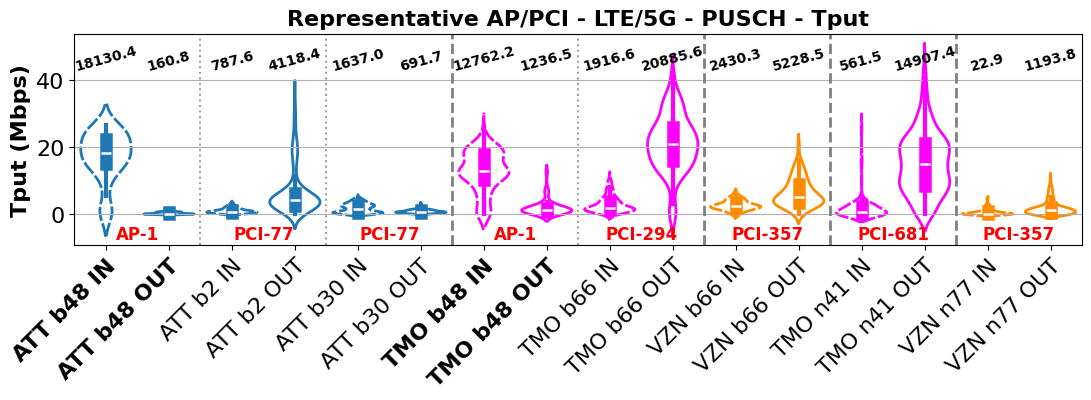

In [ ]:
# LTE/5G - PUSCH - Tput
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_att_nh_in[df_lte_pusch_att_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 IN'),
    df_lte_pusch_att_nh_out[df_lte_pusch_att_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 OUT'),
    df_lte_pusch_att_mno_in[(df_lte_pusch_att_mno_in['Band Number'] == 2) & (df_lte_pusch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b2 IN'),
    df_lte_pusch_att_mno_out[(df_lte_pusch_att_mno_out['Band Number'] == 2) & (df_lte_pusch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pusch_att_mno_in[(df_lte_pusch_att_mno_in['Band Number'] == 30) & (df_lte_pusch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b30 IN'),
    df_lte_pusch_att_mno_out[(df_lte_pusch_att_mno_out['Band Number'] == 30) & (df_lte_pusch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b30 OUT'),
    df_lte_pusch_tmo_nh_in[df_lte_pusch_tmo_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 IN'),
    df_lte_pusch_tmo_nh_out[df_lte_pusch_tmo_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 OUT'),
    df_lte_pusch_tmo_mno_in[(df_lte_pusch_tmo_mno_in['Band Number']==66) & (df_lte_pusch_tmo_mno_in['PCI'] == 294)].assign(Collection_plot='TMO b66 IN'),
    df_lte_pusch_tmo_mno_out[(df_lte_pusch_tmo_mno_out['Band Number']==66) & (df_lte_pusch_tmo_mno_out['PCI'] == 294)].assign(Collection_plot='TMO b66 OUT'),
    df_lte_pusch_vzn_mno_in[(df_lte_pusch_vzn_mno_in['Band Number'] == 66) & (df_lte_pusch_vzn_mno_in['PCI'] == 357)].assign(Collection_plot='VZN b66 IN'),
    df_lte_pusch_vzn_mno_out[(df_lte_pusch_vzn_mno_out['Band Number'] == 66) & (df_lte_pusch_vzn_mno_out['PCI'] == 357)].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pusch_tmo_mno_in[(df_5g_pusch_tmo_mno_in['Band Number']==41) & (df_5g_pusch_tmo_mno_in['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 IN'),
    df_5g_pusch_tmo_mno_out[(df_5g_pusch_tmo_mno_out['Band Number']==41) & (df_5g_pusch_tmo_mno_out['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 OUT'),
    df_5g_pusch_vzn_mno_in[(df_5g_pusch_vzn_mno_in['Band Number']==77) & (df_5g_pusch_vzn_mno_in['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 IN'),
    df_5g_pusch_vzn_mno_out[(df_5g_pusch_vzn_mno_out['Band Number']==77) & (df_5g_pusch_vzn_mno_out['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='Net PUSCH Throughput', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 16, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=13.5, color='gray', linestyle='--', linewidth=2)

plt.axvline(x=1.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=3.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=7.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
ax.text(1/16, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(3/16, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(5/16, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(7/16, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(9/16, 0.05, 'PCI-294', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(11/16, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(13/16, 0.05, 'PCI-681', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(15/16, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
medians = data.groupby('Collection_plot')['Net PUSCH Throughput'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 43e3, f'{median_value:.1f}', horizontalalignment='center', color='black', fontsize=10, fontweight='bold', rotation=15)

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
plt.title('Representative AP/PCI - LTE/5G - PUSCH - Tput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

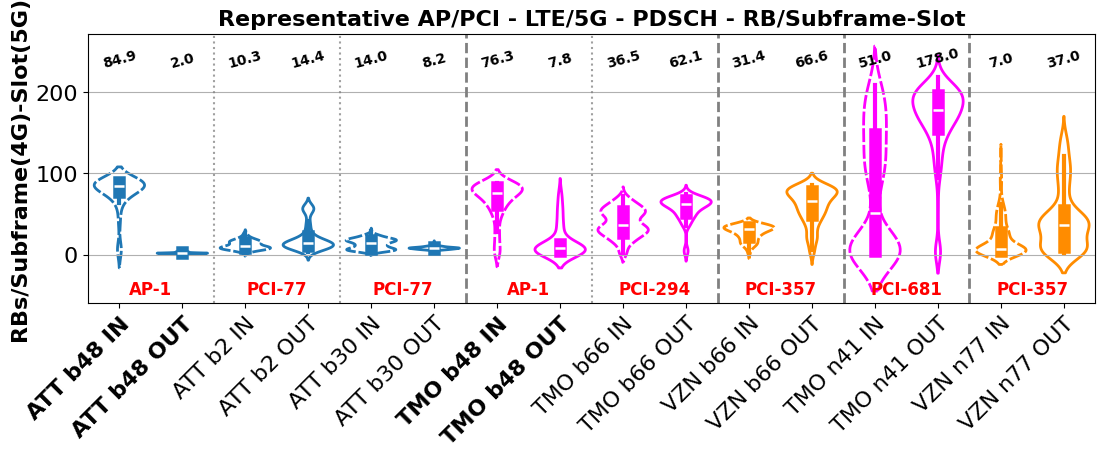

In [ ]:
# LTE/5G - PDSCH - RB/Subframe-Slot
fig, ax = plt.subplots(figsize=(13, 3.5))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_att_nh_in[df_lte_pusch_att_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 IN'),
    df_lte_pusch_att_nh_out[df_lte_pusch_att_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 OUT'),
    df_lte_pusch_att_mno_in[(df_lte_pusch_att_mno_in['Band Number'] == 2) & (df_lte_pusch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b2 IN'),
    df_lte_pusch_att_mno_out[(df_lte_pusch_att_mno_out['Band Number'] == 2) & (df_lte_pusch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pusch_att_mno_in[(df_lte_pusch_att_mno_in['Band Number'] == 30) & (df_lte_pusch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b30 IN'),
    df_lte_pusch_att_mno_out[(df_lte_pusch_att_mno_out['Band Number'] == 30) & (df_lte_pusch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b30 OUT'),
    df_lte_pusch_tmo_nh_in[df_lte_pusch_tmo_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 IN'),
    df_lte_pusch_tmo_nh_out[df_lte_pusch_tmo_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 OUT'),
    df_lte_pusch_tmo_mno_in[(df_lte_pusch_tmo_mno_in['Band Number']==66) & (df_lte_pusch_tmo_mno_in['PCI'] == 294)].assign(Collection_plot='TMO b66 IN'),
    df_lte_pusch_tmo_mno_out[(df_lte_pusch_tmo_mno_out['Band Number']==66) & (df_lte_pusch_tmo_mno_out['PCI'] == 294)].assign(Collection_plot='TMO b66 OUT'),
    df_lte_pusch_vzn_mno_in[(df_lte_pusch_vzn_mno_in['Band Number'] == 66) & (df_lte_pusch_vzn_mno_in['PCI'] == 357)].assign(Collection_plot='VZN b66 IN'),
    df_lte_pusch_vzn_mno_out[(df_lte_pusch_vzn_mno_out['Band Number'] == 66) & (df_lte_pusch_vzn_mno_out['PCI'] == 357)].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pusch_tmo_mno_in[(df_5g_pusch_tmo_mno_in['Band Number']==41) & (df_5g_pusch_tmo_mno_in['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 IN'),
    df_5g_pusch_tmo_mno_out[(df_5g_pusch_tmo_mno_out['Band Number']==41) & (df_5g_pusch_tmo_mno_out['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 OUT'),
    df_5g_pusch_vzn_mno_in[(df_5g_pusch_vzn_mno_in['Band Number']==77) & (df_5g_pusch_vzn_mno_in['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 IN'),
    df_5g_pusch_vzn_mno_out[(df_5g_pusch_vzn_mno_out['Band Number']==77) & (df_5g_pusch_vzn_mno_out['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='RB per Subframe-Slot', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 16, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=13.5, color='gray', linestyle='--', linewidth=2)

plt.axvline(x=1.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=3.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=7.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
ax.text(1/16, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(3/16, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(5/16, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(7/16, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(9/16, 0.05, 'PCI-294', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(11/16, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(13/16, 0.05, 'PCI-681', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(15/16, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
medians = data.groupby('Collection_plot')['RB per Subframe-Slot'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, 230, f'{median_value:.1f}', horizontalalignment='center', color='black', fontsize=10, fontweight='bold', rotation=15)

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RBs/Subframe(4G)-Slot(5G)', fontsize=16, fontweight='bold')
plt.title('Representative AP/PCI - LTE/5G - PDSCH - RB/Subframe-Slot', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

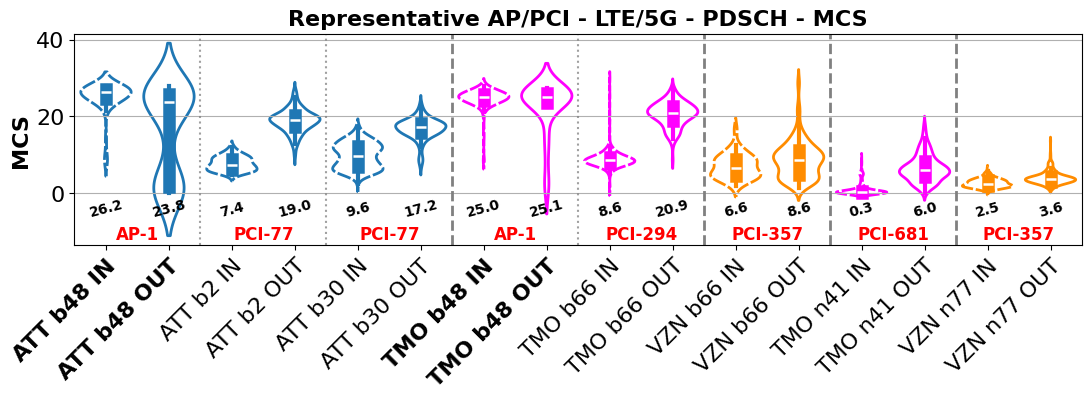

In [ ]:
# LTE/5G - PDSCH - MCS
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_att_nh_in[df_lte_pusch_att_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 IN'),
    df_lte_pusch_att_nh_out[df_lte_pusch_att_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 OUT'),
    df_lte_pusch_att_mno_in[(df_lte_pusch_att_mno_in['Band Number'] == 2) & (df_lte_pusch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b2 IN'),
    df_lte_pusch_att_mno_out[(df_lte_pusch_att_mno_out['Band Number'] == 2) & (df_lte_pusch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pusch_att_mno_in[(df_lte_pusch_att_mno_in['Band Number'] == 30) & (df_lte_pusch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b30 IN'),
    df_lte_pusch_att_mno_out[(df_lte_pusch_att_mno_out['Band Number'] == 30) & (df_lte_pusch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b30 OUT'),
    df_lte_pusch_tmo_nh_in[df_lte_pusch_tmo_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 IN'),
    df_lte_pusch_tmo_nh_out[df_lte_pusch_tmo_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 OUT'),
    df_lte_pusch_tmo_mno_in[(df_lte_pusch_tmo_mno_in['Band Number']==66) & (df_lte_pusch_tmo_mno_in['PCI'] == 294)].assign(Collection_plot='TMO b66 IN'),
    df_lte_pusch_tmo_mno_out[(df_lte_pusch_tmo_mno_out['Band Number']==66) & (df_lte_pusch_tmo_mno_out['PCI'] == 294)].assign(Collection_plot='TMO b66 OUT'),
    df_lte_pusch_vzn_mno_in[(df_lte_pusch_vzn_mno_in['Band Number'] == 66) & (df_lte_pusch_vzn_mno_in['PCI'] == 357)].assign(Collection_plot='VZN b66 IN'),
    df_lte_pusch_vzn_mno_out[(df_lte_pusch_vzn_mno_out['Band Number'] == 66) & (df_lte_pusch_vzn_mno_out['PCI'] == 357)].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pusch_tmo_mno_in[(df_5g_pusch_tmo_mno_in['Band Number']==41) & (df_5g_pusch_tmo_mno_in['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 IN'),
    df_5g_pusch_tmo_mno_out[(df_5g_pusch_tmo_mno_out['Band Number']==41) & (df_5g_pusch_tmo_mno_out['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 OUT'),
    df_5g_pusch_vzn_mno_in[(df_5g_pusch_vzn_mno_in['Band Number']==77) & (df_5g_pusch_vzn_mno_in['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 IN'),
    df_5g_pusch_vzn_mno_out[(df_5g_pusch_vzn_mno_out['Band Number']==77) & (df_5g_pusch_vzn_mno_out['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 OUT')
])
sns.violinplot(data=data.dropna(subset='MCS'), x='Collection_plot', y='MCS', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 16, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=13.5, color='gray', linestyle='--', linewidth=2)

plt.axvline(x=1.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=3.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=7.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
ax.text(1/16, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(3/16, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(5/16, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(7/16, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(9/16, 0.05, 'PCI-294', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(11/16, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(13/16, 0.05, 'PCI-681', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(15/16, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
medians = data.groupby('Collection_plot')['MCS'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, -6, f'{median_value:.1f}', horizontalalignment='center', color='black', fontsize=10, fontweight='bold', rotation=15)

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('MCS', fontsize=16, fontweight='bold')
plt.title('Representative AP/PCI - LTE/5G - PDSCH - MCS', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

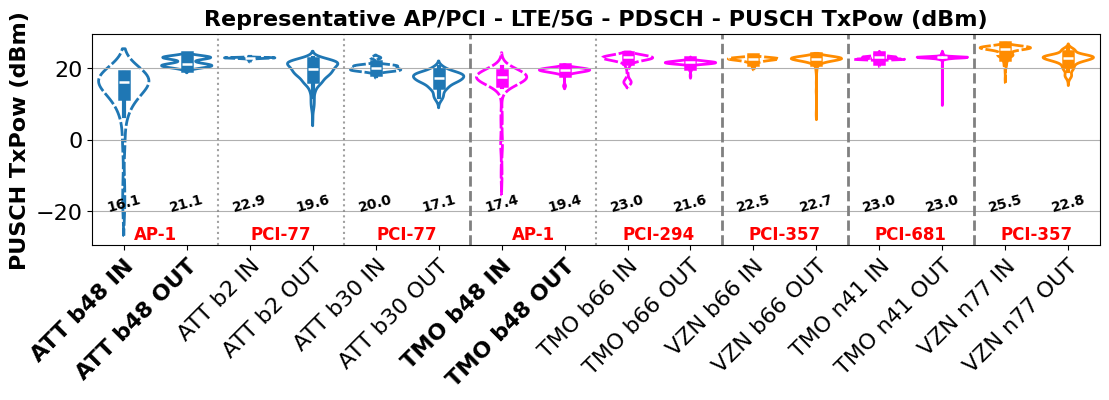

In [ ]:
# LTE/5G - PDSCH - PUSCH Tx Power
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_pusch_att_nh_in[df_lte_pusch_att_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 IN'),
    df_lte_pusch_att_nh_out[df_lte_pusch_att_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='ATT b48 OUT'),
    df_lte_pusch_att_mno_in[(df_lte_pusch_att_mno_in['Band Number'] == 2) & (df_lte_pusch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b2 IN'),
    df_lte_pusch_att_mno_out[(df_lte_pusch_att_mno_out['Band Number'] == 2) & (df_lte_pusch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b2 OUT'),
    df_lte_pusch_att_mno_in[(df_lte_pusch_att_mno_in['Band Number'] == 30) & (df_lte_pusch_att_mno_in['PCI'] == 77)].assign(Collection_plot='ATT b30 IN'),
    df_lte_pusch_att_mno_out[(df_lte_pusch_att_mno_out['Band Number'] == 30) & (df_lte_pusch_att_mno_out['PCI'] == 77)].assign(Collection_plot='ATT b30 OUT'),
    df_lte_pusch_tmo_nh_in[df_lte_pusch_tmo_nh_in['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 IN'),
    df_lte_pusch_tmo_nh_out[df_lte_pusch_tmo_nh_out['PCI'].isin([4, 7])].assign(Collection_plot='TMO b48 OUT'),
    df_lte_pusch_tmo_mno_in[(df_lte_pusch_tmo_mno_in['Band Number']==66) & (df_lte_pusch_tmo_mno_in['PCI'] == 294)].assign(Collection_plot='TMO b66 IN'),
    df_lte_pusch_tmo_mno_out[(df_lte_pusch_tmo_mno_out['Band Number']==66) & (df_lte_pusch_tmo_mno_out['PCI'] == 294)].assign(Collection_plot='TMO b66 OUT'),
    df_lte_pusch_vzn_mno_in[(df_lte_pusch_vzn_mno_in['Band Number'] == 66) & (df_lte_pusch_vzn_mno_in['PCI'] == 357)].assign(Collection_plot='VZN b66 IN'),
    df_lte_pusch_vzn_mno_out[(df_lte_pusch_vzn_mno_out['Band Number'] == 66) & (df_lte_pusch_vzn_mno_out['PCI'] == 357)].assign(Collection_plot='VZN b66 OUT'),
    df_5g_pusch_tmo_mno_in[(df_5g_pusch_tmo_mno_in['Band Number']==41) & (df_5g_pusch_tmo_mno_in['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 IN'),
    df_5g_pusch_tmo_mno_out[(df_5g_pusch_tmo_mno_out['Band Number']==41) & (df_5g_pusch_tmo_mno_out['PCI']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 OUT'),
    df_5g_pusch_vzn_mno_in[(df_5g_pusch_vzn_mno_in['Band Number']==77) & (df_5g_pusch_vzn_mno_in['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 IN'),
    df_5g_pusch_vzn_mno_out[(df_5g_pusch_vzn_mno_out['Band Number']==77) & (df_5g_pusch_vzn_mno_out['PCI']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 OUT')
])
sns.violinplot(data=data.dropna(subset='PUSCH Tx Power'), x='Collection_plot', y='PUSCH Tx Power', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 16, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=13.5, color='gray', linestyle='--', linewidth=2)

plt.axvline(x=1.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=3.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=7.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
ax.text(1/16, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(3/16, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(5/16, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(7/16, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(9/16, 0.05, 'PCI-294', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(11/16, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(13/16, 0.05, 'PCI-681', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(15/16, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
medians = data.groupby('Collection_plot')['PUSCH Tx Power'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, -20, f'{median_value:.1f}', horizontalalignment='center', color='black', fontsize=10, fontweight='bold', rotation=15)

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('PUSCH TxPow (dBm)', fontsize=16, fontweight='bold')
plt.title('Representative AP/PCI - LTE/5G - PDSCH - PUSCH TxPow (dBm)', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels